In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model

import os
import random
import numpy as np
import tensorflow as tf

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # 아래 설정은 GPU 사용 시에도 deterministic behavior 강화
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

seed_everything(42)

import warnings
warnings.filterwarnings(action='ignore')

sns.set_theme(style="whitegrid", palette="Set2")

# 한글 설정
plt.rc("font", family="AppleGothic")
plt.rcParams['axes.unicode_minus'] = False   

- 목표:
    - 사람별 라이프로그 + MMSE 기반으로 CN vs (MCI+Dem) 이진 분류
    - 단일 시퀀스 단위 예측 후 → 사람 단위로 재평가

# 1. 라벨 정의

## Load Data

In [3]:
# Train
train_sleep_df = pd.read_csv("data/train/raw/train_sleep.csv")
train_activity_df = pd.read_csv("data/train/raw/train_activity.csv") 
train_mmse_df = pd.read_csv("data/train/raw/train_mmse.csv") 
train_labels = pd.read_csv("data/train/label/1.걸음걸이/training_label.csv")

# Test
test_sleep_df = pd.read_csv("data/validation/raw/val_sleep.csv")
test_activity_df = pd.read_csv("data/validation/raw/val_activity.csv") 
test_mmse_df = pd.read_csv("data/validation/raw/val_mmse.csv")
test_labels = pd.read_csv("data/validation/label/1.걸음걸이/val_label.csv")

In [4]:
train_sleep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 36 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   EMAIL                                     9705 non-null   object 
 1   sleep_awake                               9705 non-null   int64  
 2   sleep_bedtime_end                         9705 non-null   object 
 3   sleep_bedtime_start                       9705 non-null   object 
 4   sleep_breath_average                      9705 non-null   float64
 5   sleep_deep                                9705 non-null   int64  
 6   sleep_duration                            9705 non-null   int64  
 7   sleep_efficiency                          9705 non-null   int64  
 8   sleep_hr_5min                             9705 non-null   object 
 9   sleep_hr_average                          9705 non-null   float64
 10  sleep_hr_lowest                     

In [5]:
train_sleep_df.head()

EMAIL  sleep_awake          sleep_bedtime_end  \
0  nia+279@rowan.kr         8700  2020-10-19T05:10:28+09:00   
1  nia+279@rowan.kr         6570  2020-10-20T05:37:52+09:00   
2  nia+279@rowan.kr        10530  2020-10-21T05:45:28+09:00   
3  nia+279@rowan.kr         4080  2020-10-22T05:12:16+09:00   
4  nia+279@rowan.kr         7170  2020-10-23T02:23:30+09:00   

         sleep_bedtime_start  sleep_breath_average  sleep_deep  \
0  2020-10-18T18:38:28+09:00                17.875       10110   
1  2020-10-19T21:39:52+09:00                18.000        7440   
2  2020-10-20T20:51:28+09:00                18.000        4620   
3  2020-10-21T22:08:16+09:00                17.500        7440   
4  2020-10-22T20:38:30+09:00                17.875        4320   

   sleep_duration  sleep_efficiency sleep_hr_5min  sleep_hr_average  ...  \
0           37920                77           ...             53.04  ...   
1           28680                77           ...             52.82  ...   
2           32040                67           ...             52.01  ...   
3           25440                84           ...             51.07  ...   
4           20700                65           ...             50.80  ...   

   sleep_score_efficiency sleep_score_latency  sleep_score_rem  \
0                      65                  89               56   
1                      65                  97               43   
2                      41                  75               68   
3                      81                  83               73   
4                      39                  78               25   

   sleep_score_total  sleep_temperature_delta  sleep_temperature_deviation  \
0                 94                     0.00                         0.00   
1                 65                     0.34                         0.34   
2                 62                    -0.07                        -0.07   
3                 62                    -0.14                        -0.14   
4                 29                    -0.50                        -0.50   

   sleep_total                  CONVERT(sleep_hr_5min USING utf8)  \
0        29220  63/61/59/58/58/58/56/55/54/53/53/53/0/0/54/57/...   
1        22110  0/51/0/51/52/52/52/52/53/53/53/52/52/53/53/53/...   
2        21510  54/56/0/55/53/55/56/55/0/55/54/54/54/0/0/55/55...   
3        21360  0/54/53/53/54/54/54/53/53/53/53/54/51/50/51/51...   
4        13530  0/49/50/50/50/50/50/50/51/0/0/0/0/0/0/0/0/50/5...   

            CONVERT(sleep_hypnogram_5min USING utf8)  \
0  4/2/2/2/2/1/1/2/2/2/2/2/4/4/4/1/1/4/4/4/2/2/2/...   
1  4/2/4/2/2/2/1/1/1/2/2/3/3/3/3/3/3/3/1/1/1/4/4/...   
2  4/2/1/1/2/2/4/4/4/4/2/2/2/4/4/4/2/4/4/4/4/4/4/...   
3  4/4/1/1/1/1/1/1/1/1/1/4/2/2/2/2/1/1/1/1/1/4/2/...   
4  4/2/2/2/2/1/1/1/2/4/4/4/4/4/4/4/4/4/2/1/1/1/1/...   

                CONVERT(sleep_rmssd_5min USING utf8)  
0  18/28/25/28/34/34/35/45/54/36/36/60/0/0/34/22/...  
1  0/49/0/38/51/17/18/18/26/27/24/29/36/31/32/34/...  
2  56/47/0/49/42/57/44/49/0/46/54/47/55/0/0/55/53...  
3  0/40/40/40/37/46/35/46/44/56/50/48/41/55/55/50...  
4  0/81/60/74/62/63/56/78/81/0/0/0/0/0/0/0/0/60/4...  

[5 rows x 36 columns]

In [6]:
train_labels.groupby('DIAG_NM').count()

SAMPLE_EMAIL
DIAG_NM              
CN                 85
Dem                 9
MCI                47

In [7]:
test_labels.groupby('DIAG_NM').count()

SAMPLE_EMAIL
DIAG_NM              
CN                 26
Dem                 3
MCI                 4

## Split Train/Test

### 현재 데이터 구성

| Set   | CN | MCI | Dem | Total |
|-------|----|-----|-----|-------|
| Train | 85 | 47  | 9   | 141   |
| Test  | 26 | 4   | 3   | 33    |

- 총 174명  
- CN: 111명, MCI: 51명, Dem: 12명
- 비정상군(MCI + Dem): 63명

---

### 라벨 처리 단계
1. CN, MCI, Dem 각각 분리
2. 각 그룹에서 train:test = 8:2 split
3. 분할된 MCI와 Dem을 합쳐서 Abnormal로 처리
4. 비정상군 수가 test set에 10명 이상인지 확인

---

In [8]:
# 전체 라벨 데이터 로드
label_df = pd.concat([train_labels, test_labels])

# CN, MCI, Dem 그룹 분리
cn_df = label_df[label_df["DIAG_NM"] == "CN"].drop_duplicates("SAMPLE_EMAIL")
mci_df = label_df[label_df["DIAG_NM"] == "MCI"].drop_duplicates("SAMPLE_EMAIL")
dem_df = label_df[label_df["DIAG_NM"] == "Dem"].drop_duplicates("SAMPLE_EMAIL")

# 각각 stratified split (8:2)
cn_train, cn_test = train_test_split(cn_df, test_size=0.2, random_state=42)
mci_train, mci_test = train_test_split(mci_df, test_size=0.2, random_state=42)
dem_train, dem_test = train_test_split(dem_df, test_size=0.2, random_state=42)

# train/test set 결합
train_df = pd.concat([cn_train, mci_train, dem_train], ignore_index=True)
test_df = pd.concat([cn_test, mci_test, dem_test], ignore_index=True)

# 비정상군(MCI + Dem) 마킹
train_df["label"] = train_df["DIAG_NM"].replace({"CN": "Normal", "MCI": "Abnormal", "Dem": "Abnormal"})
test_df["label"] = test_df["DIAG_NM"].replace({"CN": "Normal", "MCI": "Abnormal", "Dem": "Abnormal"})

# ✅ 분포 확인
print("Train 분포:\n", train_df["label"].value_counts())
print("Test 분포:\n", test_df["label"].value_counts())


Train 분포:
 label
Normal      88
Abnormal    49
Name: count, dtype: int64
Test 분포:
 label
Normal      23
Abnormal    14
Name: count, dtype: int64


# 2. EDA

In [9]:
# EDA를 위한 병합 함수 정의
def merge_for_eda(sleep_df, activity_df, mmse_df, label_df):
    # 병합 대상 열: EMAIL 기준으로 내부 조인
    merged_df = label_df.copy()
    
    merged_df = merged_df.merge(sleep_df, on="EMAIL", how="left")

    # 정렬 기준 맞추기 (안전하게)
    activity_df = activity_df.sort_values(["EMAIL", "activity_day_start"]).reset_index(drop=True)
    merged_df = merged_df.sort_values(["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)

    # 열 병합 (가로 방향)
    merged_df = pd.concat([merged_df, activity_df.drop(columns=["EMAIL"])], axis=1)
    merged_df = merged_df.merge(mmse_df, on="EMAIL", how="left")
    
    return merged_df

# 이메일 컬럼명을 SAMPLE_EMAIL로 통일
def unify_email_column(df):
    if "SAMPLE_EMAIL" in df.columns:
        df = df.rename(columns={"SAMPLE_EMAIL":"EMAIL"})
    return df

# 컬럼명 통일
train_sleep_df = unify_email_column(train_sleep_df)
train_activity_df = unify_email_column(train_activity_df)
train_mmse_df = unify_email_column(train_mmse_df)
train_df = unify_email_column(train_df)

test_sleep_df = unify_email_column(test_sleep_df)
test_activity_df = unify_email_column(test_activity_df)
test_mmse_df = unify_email_column(test_mmse_df)
test_df = unify_email_column(test_df)


In [10]:
# 1. activity + sleep concat
all_sleep_df = pd.concat([train_sleep_df, test_sleep_df], ignore_index=True)
all_activity_df = pd.concat([train_activity_df, test_activity_df], ignore_index=True)

# 날짜 기준 정렬
all_sleep_df = all_sleep_df.sort_values(["EMAIL", "sleep_bedtime_start"]).reset_index(drop=True)
all_activity_df = all_activity_df.sort_values(["EMAIL", "activity_day_start"]).reset_index(drop=True)

# concat (가로 방향으로)
daily_df = pd.concat([all_activity_df, all_sleep_df.drop(columns=["EMAIL"])], axis=1)

In [11]:
# mmse 병합용 전체 df
all_mmse_df = pd.concat([train_mmse_df, test_mmse_df], ignore_index=True)

# DIAG_NM 제거 (지시 반영)
if "DIAG_NM" in all_mmse_df.columns:
    all_mmse_df = all_mmse_df.drop(columns="DIAG_NM")

# MMSE 점수 숫자형 변환
all_mmse_df["TOTAL"] = pd.to_numeric(all_mmse_df["TOTAL"], errors="coerce")

# 가장 높은 TOTAL 기준으로 대표 점수 선택
mmse_agg = all_mmse_df.drop_duplicates("EMAIL")

#### MMSE 문항별 컬럼명 매핑

| 기존 변수 | 변경 제안 (영문명) | 의미 요약 |
|-----------|------------------|-----------------------------|
| Q01 | year | 올해가 몇 년이죠? |
| Q02 | season | 지금은 어떤 계절이죠? |
| Q03 | day_of_month | 오늘이 며칠입니까? |
| Q04 | weekday | 오늘이 무슨 요일인가요? |
| Q05 | month | 몇 월입니까? |
| Q06 | country | 지금 있는 나라는? |
| Q07 | province | 시(도)는? |
| Q08 | place_name | 이곳은 어디입니까? |
| Q09 | floor | 몇 층입니까? |
| Q10 | place_function | 여기에서는 어떤 일을 하나요? |
| Q11_1 | memory_plane | 기억단어: 비행기 |
| Q11_2 | memory_pencil | 기억단어: 연필 |
| Q11_3 | memory_pinetree | 기억단어: 소나무 |
| Q12_1 ~ Q12_5 | subtract_100_x (1~5) | 100에서 7씩 빼기 (주의력/계산력) |
| Q13_1 | recall_plane | 회상단어: 비행기 |
| Q13_2 | recall_pencil | 회상단어: 연필 |
| Q13_3 | recall_pinetree | 회상단어: 소나무 |
| Q14_1 | object_watch | 시계 이름 |
| Q14_2 | object_pen | 다른 물건 이름 |
| Q15 | repeat_sentence | 문장 따라 말하기 |
| Q16_1 | paper_flip | 종이 뒤집기 |
| Q16_2 | paper_fold | 반으로 접기 |
| Q16_3 | paper_return | 되돌려 주기 |
| Q17 | draw_star | 별 그리기 |
| Q18 | read_sentence | 문장 읽기 |
| Q19 | write_sentence | 문장 쓰기 |
| TOTAL | mmse_total | 총점 |

In [12]:
mmse_agg = mmse_agg.rename(columns={
    "Q01": "year",
    "Q02": "season",
    "Q03": "day_of_month",
    "Q04": "weekday",
    "Q05": "month",
    "Q06": "country",
    "Q07": "province",
    "Q08": "place_name",
    "Q09": "floor",
    "Q10": "place_function",
    "Q11_1": "memory_plane",
    "Q11_2": "memory_pencil",
    "Q11_3": "memory_pinetree",
    "Q12_1": "subtract_100_1",
    "Q12_2": "subtract_100_2",
    "Q12_3": "subtract_100_3",
    "Q12_4": "subtract_100_4",
    "Q12_5": "subtract_100_5",
    "Q13_1": "recall_plane",
    "Q13_2": "recall_pencil",
    "Q13_3": "recall_pinetree",
    "Q14_1": "object_watch",
    "Q14_2": "object_pen",
    "Q15": "repeat_sentence",
    "Q16_1": "paper_flip",
    "Q16_2": "paper_fold",
    "Q16_3": "paper_return",
    "Q17": "draw_star",
    "Q18": "read_sentence",
    "Q19": "write_sentence",
    "TOTAL": "mmse_total"
})


In [13]:
# 이메일 추출
train_emails = train_df["EMAIL"]
test_emails = test_df["EMAIL"]

# 데이터 분할
train_daily_df = daily_df[daily_df["EMAIL"].isin(train_emails)].reset_index(drop=True)
test_daily_df = daily_df[daily_df["EMAIL"].isin(test_emails)].reset_index(drop=True)

# MMSE 병합
train_daily_df = train_daily_df.merge(mmse_agg, on="EMAIL", how="left")
test_daily_df = test_daily_df.merge(mmse_agg, on="EMAIL", how="left")

# 라벨 병합
train_daily_df = train_daily_df.merge(train_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="left")
test_daily_df = test_daily_df.merge(test_df[["EMAIL", "DIAG_NM"]], on="EMAIL", how="left")

# 그룹 레이블 추가
for df in [train_daily_df, test_daily_df]:
    df["label"] = df["DIAG_NM"].replace({"CN": "Normal", "MCI": "Abnormal", "Dem": "Abnormal"})


In [14]:
print("Train Shape: ", train_daily_df.shape)
print("Test Shape:  ", test_daily_df.shape)

Train Shape:  (9557, 104)
Test Shape:   (2626, 104)


In [15]:
train_people_by_class = train_daily_df[["EMAIL", "DIAG_NM"]].drop_duplicates().groupby("DIAG_NM")["EMAIL"].count()
test_people_by_class = test_daily_df[["EMAIL", "DIAG_NM"]].drop_duplicates().groupby("DIAG_NM")["EMAIL"].count()
print("======Train======\n", train_people_by_class)
print("======Test======\n: ", test_people_by_class)

======Train======
 DIAG_NM
CN     88
Dem     9
MCI    40
Name: EMAIL, dtype: int64
======Test======
:  DIAG_NM
CN     23
Dem     3
MCI    11
Name: EMAIL, dtype: int64


### 라벨 분포 시각화

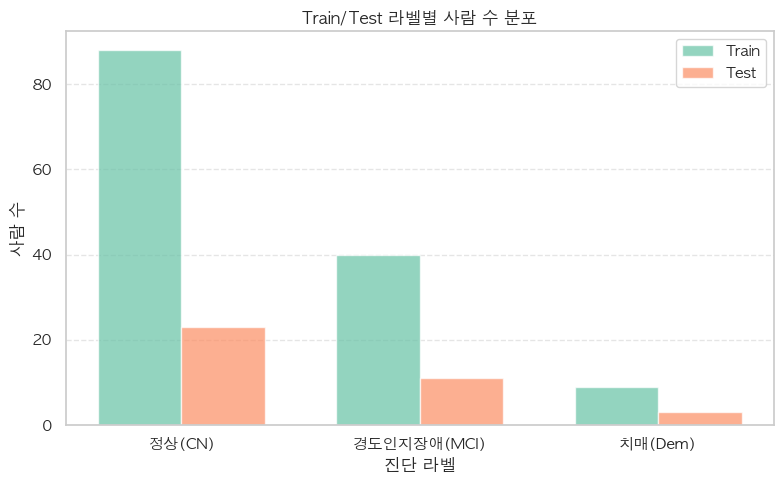

In [16]:
# 순서를 CN, MCI, Dem으로 고정하고 라벨명을 변경
labels_kor = ['정상(CN)', '경도인지장애(MCI)', '치매(Dem)']
label_order = ['CN', 'MCI', 'Dem']

# 순서에 맞게 값 정렬
train_counts_ordered = [train_people_by_class[label] for label in label_order]
test_counts_ordered = [test_people_by_class[label] for label in label_order]

x = range(len(label_order))

# 시각화
plt.figure(figsize=(8, 5))
bar_width = 0.35

plt.bar(x, train_counts_ordered, width=bar_width, label='Train', alpha=0.7)
plt.bar([i + bar_width for i in x], test_counts_ordered, width=bar_width, label='Test', alpha=0.7)

# 축 및 레이블 설정
plt.xlabel('진단 라벨')
plt.ylabel('사람 수')
plt.title('Train/Test 라벨별 사람 수 분포')
plt.xticks([i + bar_width / 2 for i in x], labels_kor)
plt.legend()
plt.grid(False)  # 격자 없애기
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

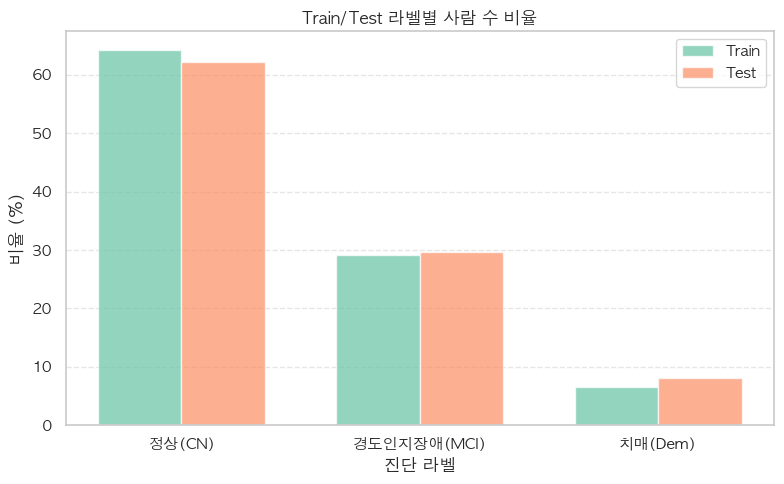

In [17]:
# 비율(%) 계산
total_train = sum(train_counts_ordered)
total_test = sum(test_counts_ordered)

train_percent = [count / total_train * 100 for count in train_counts_ordered]
test_percent = [count / total_test * 100 for count in test_counts_ordered]

# 시각화
plt.figure(figsize=(8, 5))
bar_width = 0.35

plt.bar(x, train_percent, width=bar_width, label='Train', alpha=0.7)
plt.bar([i + bar_width for i in x], test_percent, width=bar_width, label='Test', alpha=0.7)

# 축 및 레이블 설정
plt.xlabel('진단 라벨')
plt.ylabel('비율 (%)')
plt.title('Train/Test 라벨별 사람 수 비율')
plt.xticks([i + bar_width / 2 for i in x], labels_kor)
plt.legend()
plt.grid(False)  # 격자 없애기
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [18]:
# 사람 단위로 label 집계
train_group_dist = train_daily_df[["EMAIL", "label"]].drop_duplicates()["label"].value_counts().to_dict()
test_group_dist = test_daily_df[["EMAIL", "label"]].drop_duplicates()["label"].value_counts().to_dict()

train_group_dist, test_group_dist

({'Normal': 88, 'Abnormal': 49}, {'Normal': 23, 'Abnormal': 14})

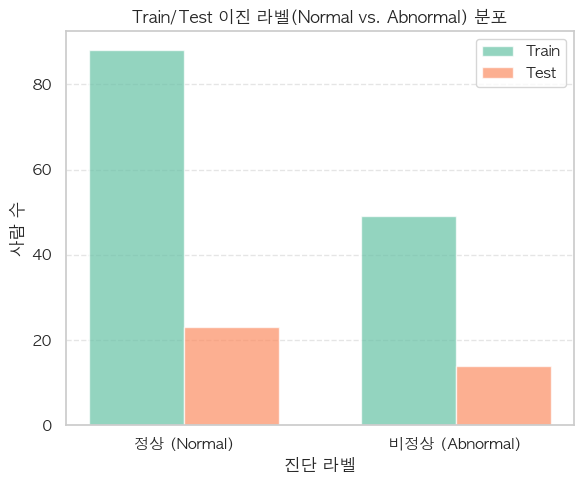

In [19]:
# 그룹 이름 고정 (Normal, Abnormal)
group_labels = ['Normal', 'Abnormal']

# 값 추출 (없는 클래스는 0으로 채움)
train_group_dist = {
    "Normal": train_group_dist.get("Normal", 0),
    "Abnormal": train_group_dist.get("Abnormal", 0)
}
test_group_dist = {
    "Normal": test_group_dist.get("Normal", 0),
    "Abnormal": test_group_dist.get("Abnormal", 0)
}

train_group_counts = [train_group_dist[label] for label in group_labels]
test_group_counts = [test_group_dist[label] for label in group_labels]
x = range(len(group_labels))

# 시각화
plt.figure(figsize=(6, 5))
bar_width = 0.35

plt.bar(x, train_group_counts, width=bar_width, label='Train', alpha=0.7)
plt.bar([i + bar_width for i in x], test_group_counts, width=bar_width, label='Test', alpha=0.7)

# 축 및 레이블 설정
plt.xlabel('진단 라벨')
plt.ylabel('사람 수')
plt.title('Train/Test 이진 라벨(Normal vs. Abnormal) 분포')
plt.xticks([i + bar_width / 2 for i in x], ['정상 (Normal)', '비정상 (Abnormal)'])
plt.legend()
plt.grid(False)  # 격자 없애기
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

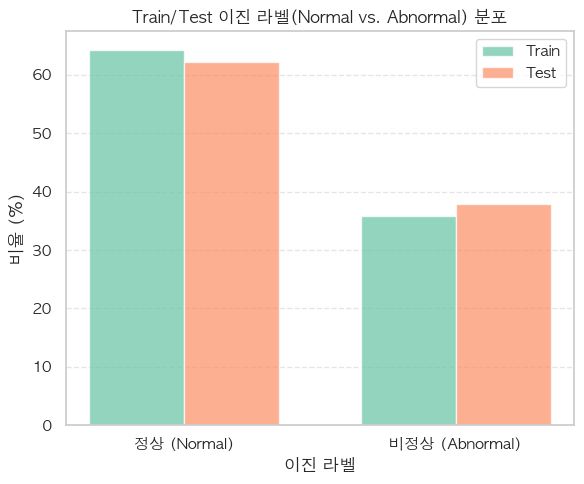

In [20]:
# 그룹 이름 고정 (Normal, Abnormal)
group_labels = ['Normal', 'Abnormal']

# 값 추출 (없는 클래스는 0으로 채움)
train_group_dist = {
    "Normal": train_group_dist.get("Normal", 0),
    "Abnormal": train_group_dist.get("Abnormal", 0)
}
test_group_dist = {
    "Normal": test_group_dist.get("Normal", 0),
    "Abnormal": test_group_dist.get("Abnormal", 0)
}

train_group_counts = [train_group_dist[label] for label in group_labels]
test_group_counts = [test_group_dist[label] for label in group_labels]

# 비율 계산
total_train_group = sum(train_group_counts)
total_test_group = sum(test_group_counts)

train_group_percent = [count / total_train_group * 100 for count in train_group_counts]
test_group_percent = [count / total_test_group * 100 for count in test_group_counts]

# 시각화
x = range(len(group_labels))
plt.figure(figsize=(6, 5))
bar_width = 0.35

plt.bar(x, train_group_percent, width=bar_width, label='Train', alpha=0.7)
plt.bar([i + bar_width for i in x], test_group_percent, width=bar_width, label='Test', alpha=0.7)

plt.xlabel('이진 라벨')
plt.ylabel('비율 (%)')
plt.title('Train/Test 이진 라벨(Normal vs. Abnormal) 분포')
plt.xticks([i + bar_width / 2 for i in x], ['정상 (Normal)', '비정상 (Abnormal)'])
plt.legend()
plt.grid(False)  # 격자 없애기
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### 1. 데이터 무결성 확인

📌 목표
- 결측치 확인 및 제거/보정 대상 식별
- 이상치(outlier), 비정상값 탐색
- 중복 데이터 존재 여부 확인

🔍 수행 항목
- `df.info()` 및 `df.isnull().sum()` → 전체 결측치 구조 파악
- sleep/activity/MMSE별로 결측률 시각화
- datetime 필드(`sleep_bedtime_start`, `activity_day_start`) 파싱/정렬
- 중복 확인: `df.duplicated(subset=['EMAIL', 날짜])`
- 이상치 탐색: `sleep_duration`, `activity_steps`, `mmse_total` 등에서 boxplot

In [21]:
print(train_daily_df.dtypes.value_counts())

int64      81
object     18
float64     5
Name: count, dtype: int64


In [22]:
df_types = pd.DataFrame(train_daily_df.dtypes, columns=["dtype"]).reset_index()
df_types.columns = ["column", "dtype"]
df_types[df_types['dtype']=='object']

column   dtype
0                                       EMAIL  object
4                         activity_class_5min  object
6                            activity_day_end  object
7                          activity_day_start  object
13                          activity_met_1min  object
29    CONVERT(activity_class_5min USING utf8)  object
30      CONVERT(activity_met_1min USING utf8)  object
32                          sleep_bedtime_end  object
33                        sleep_bedtime_start  object
38                              sleep_hr_5min  object
41                       sleep_hypnogram_5min  object
51                           sleep_rmssd_5min  object
63          CONVERT(sleep_hr_5min USING utf8)  object
64   CONVERT(sleep_hypnogram_5min USING utf8)  object
65       CONVERT(sleep_rmssd_5min USING utf8)  object
67                                  DOCTOR_NM  object
102                                   DIAG_NM  object
103                                     label  object

In [23]:
def clean_daily_df(df):
    # 1. datetime 형변환
    datetime_cols = [
        'activity_day_start', 'activity_day_end',
        'sleep_bedtime_start', 'sleep_bedtime_end'
    ]
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # 2. 불필요한 컬럼 제거
    drop_cols = [
        'activity_class_5min',
        'activity_met_1min',
        'sleep_hr_5min',
        'sleep_hypnogram_5min',
        'sleep_rmssd_5min',
        'DOCTOR_NM'
    ]
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    # 3. 컬럼명 변경 (CONVERT → 원래 이름)
    rename_dict = {
        'CONVERT(activity_class_5min USING utf8)': 'activity_class_5min',
        'CONVERT(activity_met_1min USING utf8)': 'activity_met_1min',
        'CONVERT(sleep_hr_5min USING utf8)': 'sleep_hr_5min',
        'CONVERT(sleep_hypnogram_5min USING utf8)': 'sleep_hypnogram_5min',
        'CONVERT(sleep_rmssd_5min USING utf8)': 'sleep_rmssd_5min'
    }
    df.rename(columns=rename_dict, inplace=True)

    # 4. 라벨 컬럼 category로 변환
    for label_col in ['DIAG_NM', 'label']:
        if label_col in df.columns:
            df[label_col] = df[label_col].astype('category')

    return df

train_daily_df = clean_daily_df(train_daily_df)
test_daily_df = clean_daily_df(test_daily_df)

In [24]:
df_types = pd.DataFrame(train_daily_df.dtypes, columns=["dtype"]).reset_index()
df_types.columns = ["column", "dtype"]
df_types[df_types['dtype']=='object']

column   dtype
0                  EMAIL  object
27   activity_class_5min  object
28     activity_met_1min  object
58         sleep_hr_5min  object
59  sleep_hypnogram_5min  object
60      sleep_rmssd_5min  object

In [25]:
train_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Data columns (total 98 columns):
 #   Column                             Non-Null Count  Dtype                    
---  ------                             --------------  -----                    
 0   EMAIL                              9557 non-null   object                   
 1   activity_average_met               9557 non-null   float64                  
 2   activity_cal_active                9557 non-null   int64                    
 3   activity_cal_total                 9557 non-null   int64                    
 4   activity_daily_movement            9557 non-null   int64                    
 5   activity_day_end                   9557 non-null   datetime64[ns, UTC+09:00]
 6   activity_day_start                 9557 non-null   datetime64[ns, UTC+09:00]
 7   activity_high                      9557 non-null   int64                    
 8   activity_inactive                  9557 non-null   int64            

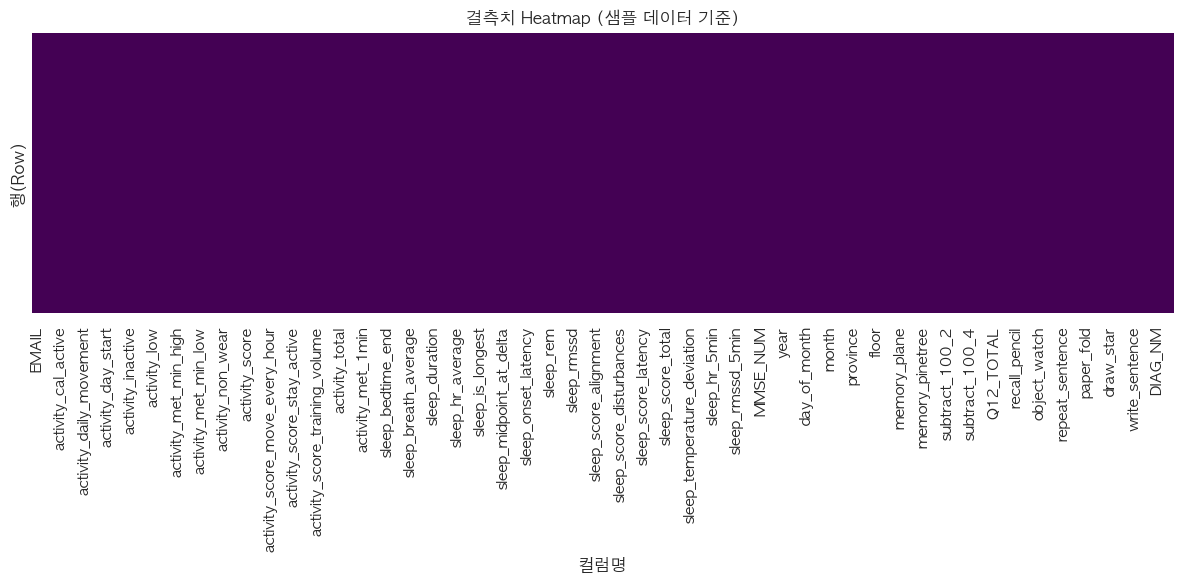

In [26]:
# 결측치 heatmap 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(train_daily_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("결측치 Heatmap (샘플 데이터 기준)")
plt.xlabel("컬럼명")
plt.ylabel("행(Row)")
plt.tight_layout()
plt.show()

- 중복 확인: EMAIL + 날짜 기준

In [27]:
# 날짜 기준 컬럼 생성
train_daily_df["date"] = pd.to_datetime(train_daily_df["activity_day_start"]).dt.date
duplicates = train_daily_df.duplicated(subset=["EMAIL", "date"])

print("중복된 (EMAIL, date) 조합 수:", duplicates.sum())
train_daily_df[duplicates].head()

중복된 (EMAIL, date) 조합 수: 0


Empty DataFrame
Columns: [EMAIL, activity_average_met, activity_cal_active, activity_cal_total, activity_daily_movement, activity_day_end, activity_day_start, activity_high, activity_inactive, activity_inactivity_alerts, activity_low, activity_medium, activity_met_min_high, activity_met_min_inactive, activity_met_min_low, activity_met_min_medium, activity_non_wear, activity_rest, activity_score, activity_score_meet_daily_targets, activity_score_move_every_hour, activity_score_recovery_time, activity_score_stay_active, activity_score_training_frequency, activity_score_training_volume, activity_steps, activity_total, activity_class_5min, activity_met_1min, sleep_awake, sleep_bedtime_end, sleep_bedtime_start, sleep_breath_average, sleep_deep, sleep_duration, sleep_efficiency, sleep_hr_average, sleep_hr_lowest, sleep_is_longest, sleep_light, sleep_midpoint_at_delta, sleep_midpoint_time, sleep_onset_latency, sleep_period_id, sleep_rem, sleep_restless, sleep_rmssd, sleep_score, sleep_score_alignment, sleep_score_deep, sleep_score_disturbances, sleep_score_efficiency, sleep_score_latency, sleep_score_rem, sleep_score_total, sleep_temperature_delta, sleep_temperature_deviation, sleep_total, sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min, DIAG_SEQ, MMSE_NUM, MMSE_KIND, year, season, day_of_month, weekday, month, country, province, place_name, floor, place_function, memory_plane, memory_pencil, memory_pinetree, subtract_100_1, subtract_100_2, subtract_100_3, subtract_100_4, subtract_100_5, Q12_TOTAL, recall_plane, recall_pencil, recall_pinetree, object_watch, object_pen, repeat_sentence, paper_flip, paper_fold, paper_return, draw_star, read_sentence, write_sentence, mmse_total, DIAG_NM, label, date]
Index: []

[0 rows x 99 columns]

### 이상치 확인

In [28]:
def get_outlier_ratio(df, threshold=1.5):
    """수치형 컬럼 전체에 대해 IQR 기반 이상치 비율 계산"""
    numeric_df = df.select_dtypes(include=['number'])
    outlier_info = {}

    for col in numeric_df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - threshold * iqr
        upper = q3 + threshold * iqr
        outlier_mask = (df[col] < lower) | (df[col] > upper)
        outlier_info[col] = outlier_mask.mean()  # 비율

    return pd.Series(outlier_info).sort_values(ascending=False)


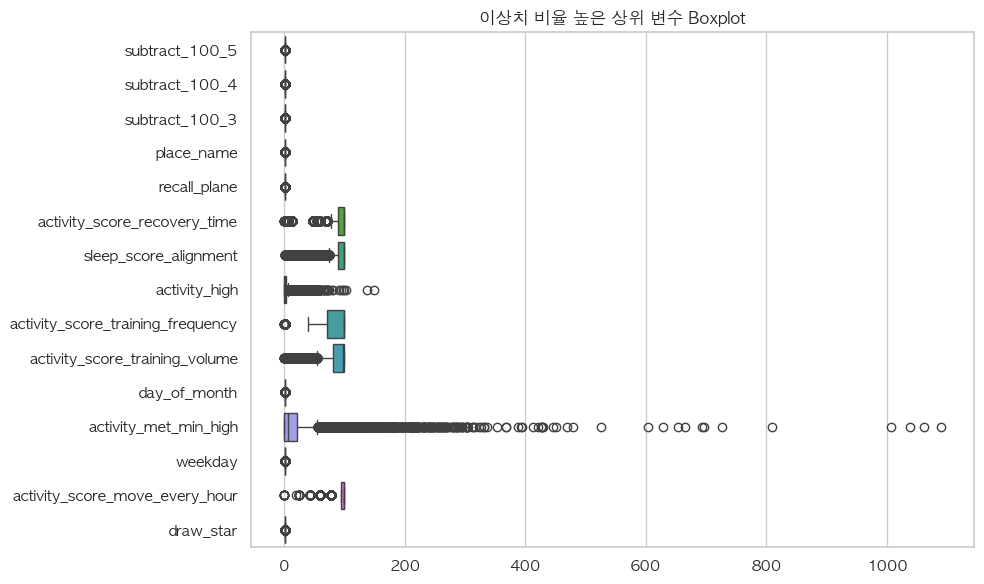

In [29]:
# 이상치 비율이 높은 변수 Top 10 시각화
outlier_ratio = get_outlier_ratio(train_daily_df)
top_cols = outlier_ratio.head(15).index.tolist()

plt.figure(figsize=(10, 6))
sns.boxplot(data=train_daily_df[top_cols], orient='h')
plt.title("이상치 비율 높은 상위 변수 Boxplot")
plt.tight_layout()
plt.show()


<Axes: xlabel='label', ylabel='activity_met_min_high'>

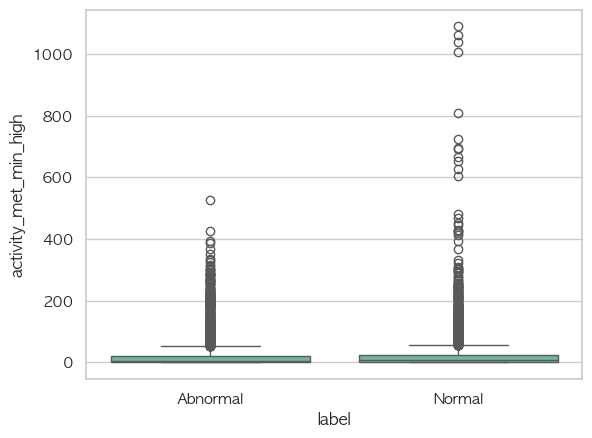

In [30]:
sns.boxplot(data=train_daily_df, x='label', y='activity_met_min_high')

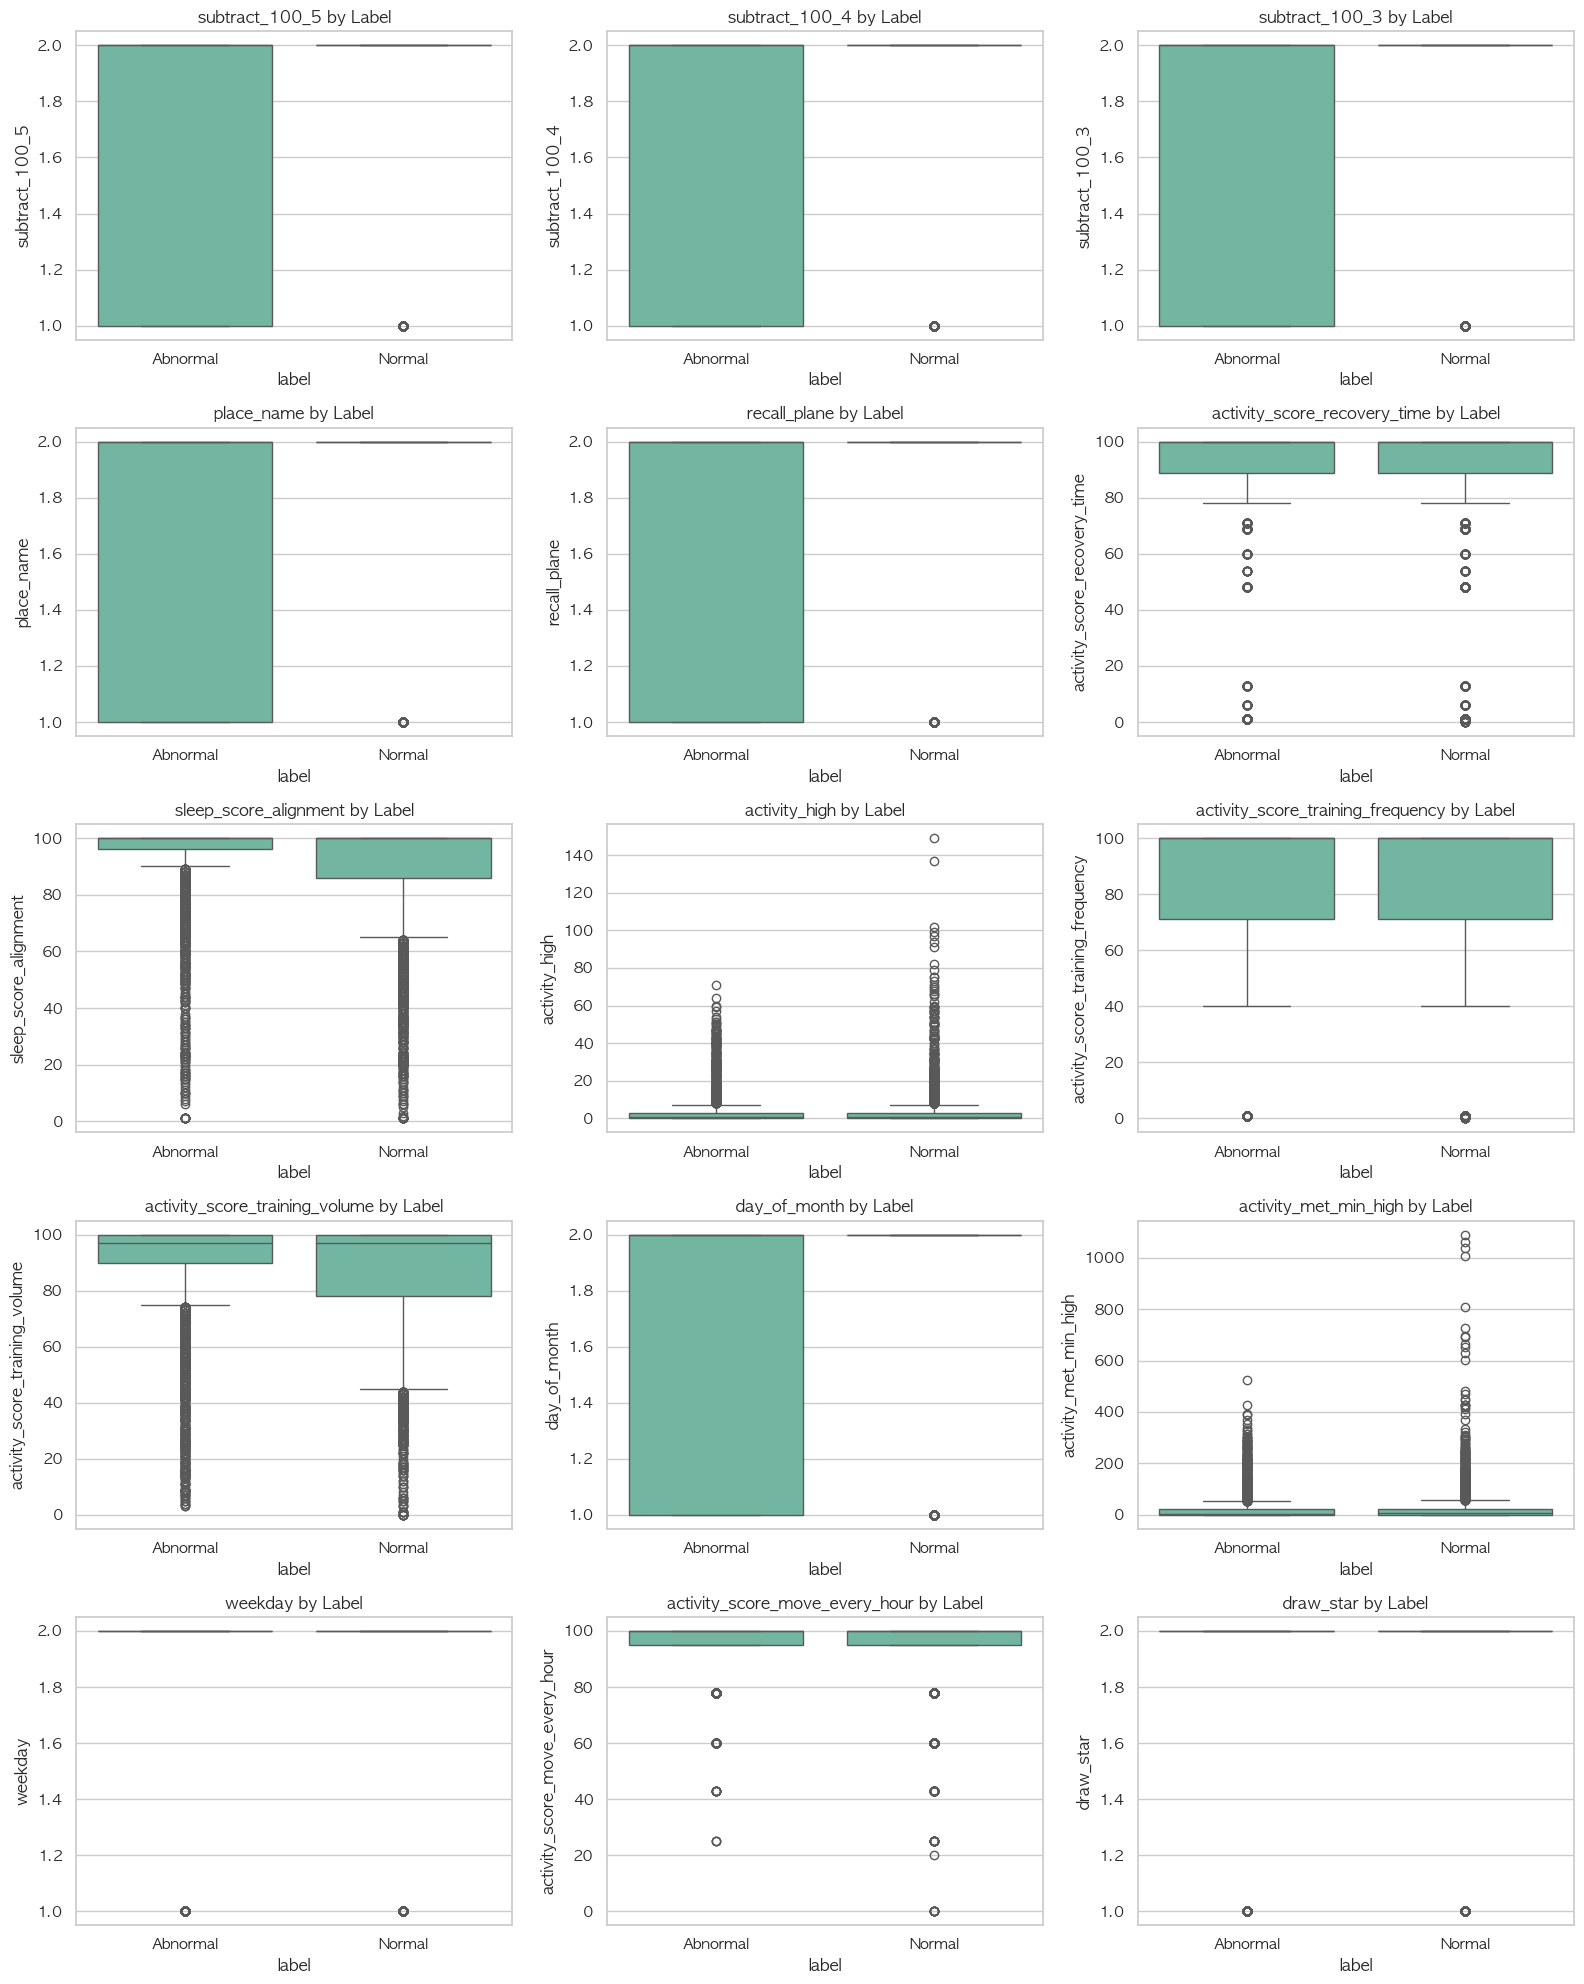

In [31]:
n_cols = 3
n_rows = -(-len(top_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(top_cols):
    sns.boxplot(data=train_daily_df, x='label', y=col, ax=axes[i])
    axes[i].set_title(f"{col} by Label")

# 나머지 빈 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



### 2. 유의미 변수 탐색

📌 목표
- 치매 여부(label)에 따라 차이 있는 변수 찾기
- 분포 비교 → 정규성 여부, 변환 필요성 확인

🔍 우선순위 변수 예시
- **활동량**: `activity_total`, `activity_steps`, `activity_score`
- **수면 질**: `sleep_duration`, `sleep_score_total`, `sleep_efficiency`
- **심박수/스트레스**: `sleep_hr_average`, `sleep_rmssd`
- **MMSE 점수**: `mmse_total`, `subtract_100`, `recall_*`, `draw_star`

🔍 수행 항목
- `group` 별 평균 및 boxplot
- 분포 시각화 (hist, kde)
- `Normal` vs `Abnormal` t-test 또는 Mann–Whitney U test
- 상관관계 분석 (`.corr()` + heatmap)

In [32]:
train_daily_df.columns

Index(['EMAIL', 'activity_average_met', 'activity_cal_active',
       'activity_cal_total', 'activity_daily_movement', 'activity_day_end',
       'activity_day_start', 'activity_high', 'activity_inactive',
       'activity_inactivity_alerts', 'activity_low', 'activity_medium',
       'activity_met_min_high', 'activity_met_min_inactive',
       'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear',
       'activity_rest', 'activity_score', 'activity_score_meet_daily_targets',
       'activity_score_move_every_hour', 'activity_score_recovery_time',
       'activity_score_stay_active', 'activity_score_training_frequency',
       'activity_score_training_volume', 'activity_steps', 'activity_total',
       'activity_class_5min', 'activity_met_1min', 'sleep_awake',
       'sleep_bedtime_end', 'sleep_bedtime_start', 'sleep_breath_average',
       'sleep_deep', 'sleep_duration', 'sleep_efficiency', 'sleep_hr_average',
       'sleep_hr_lowest', 'sleep_is_longest', 'sleep_light'

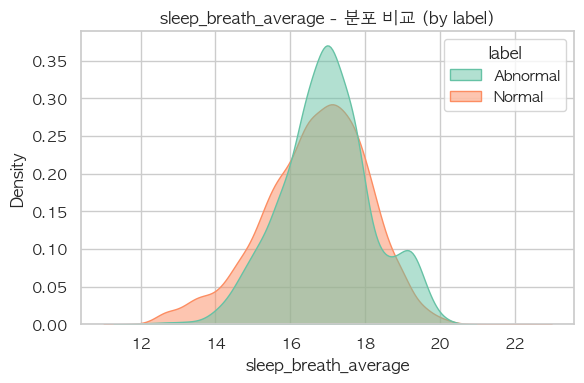

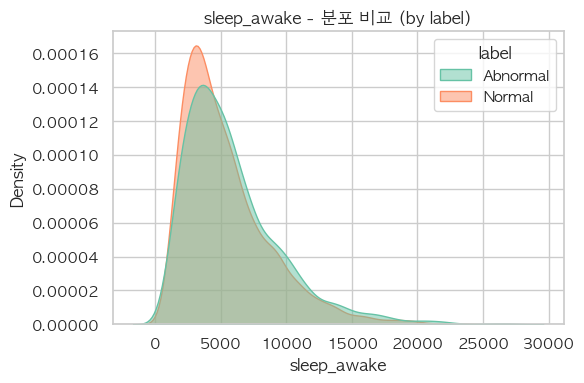

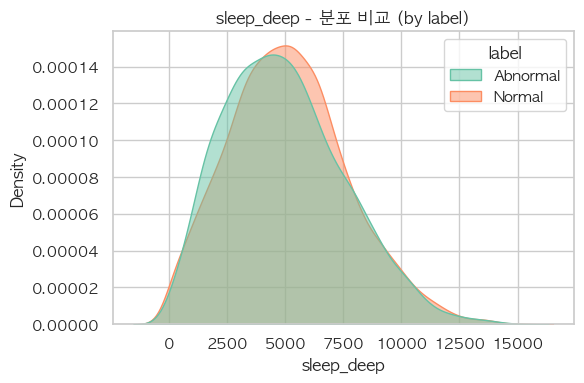

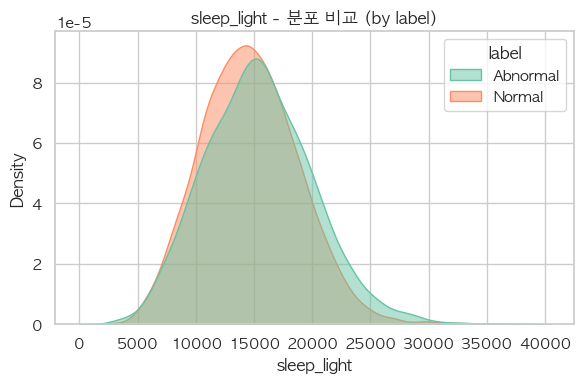

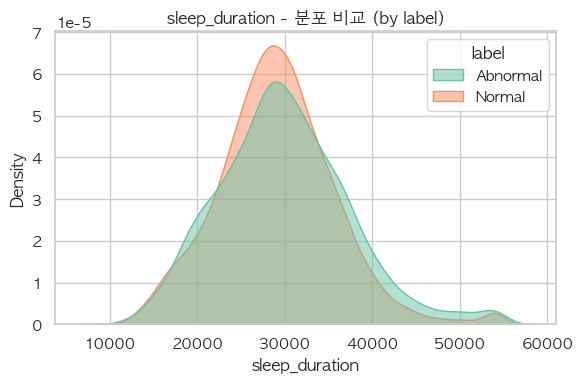

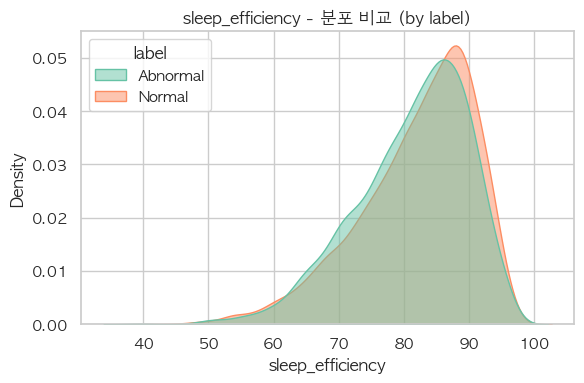

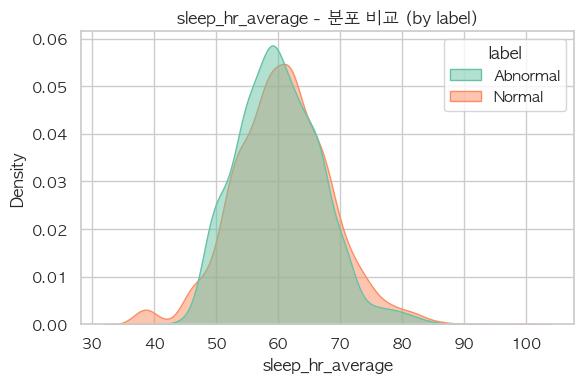

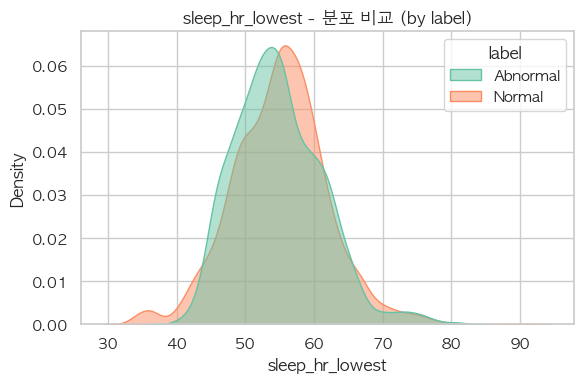

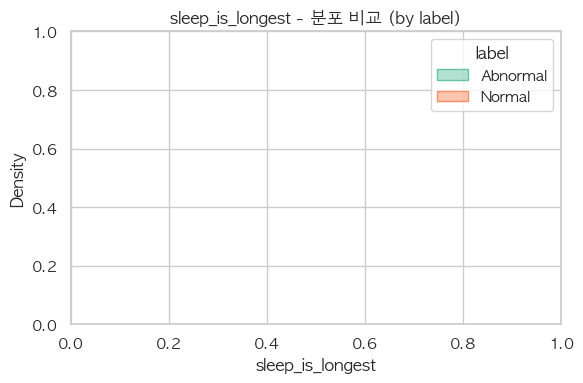

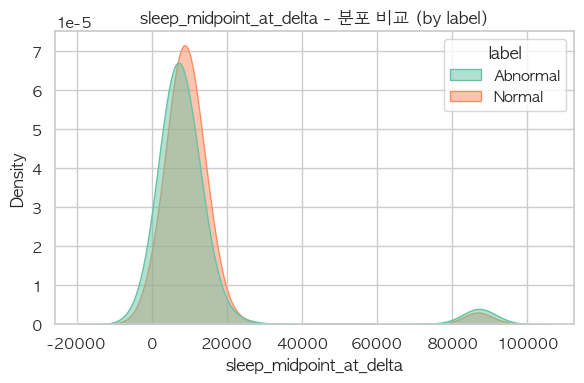

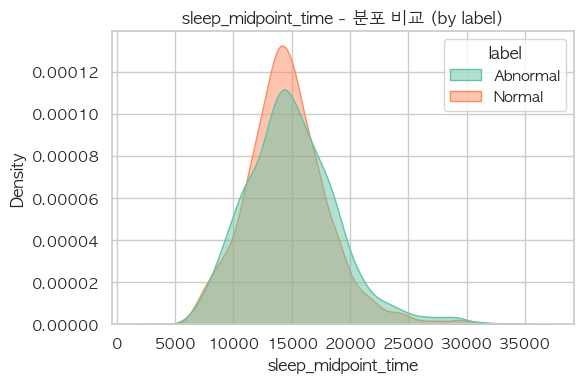

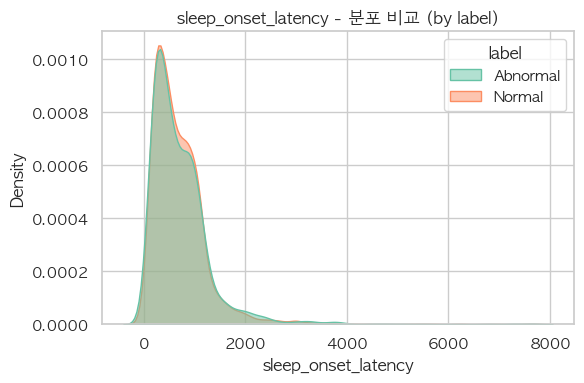

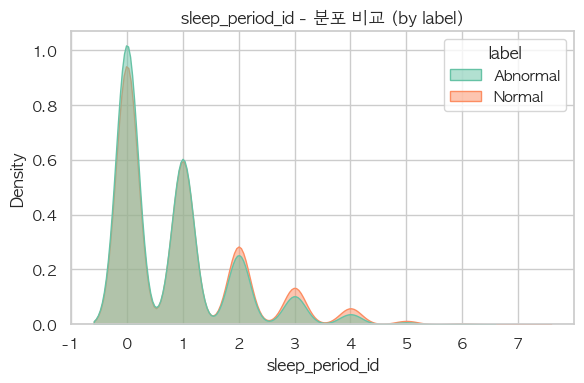

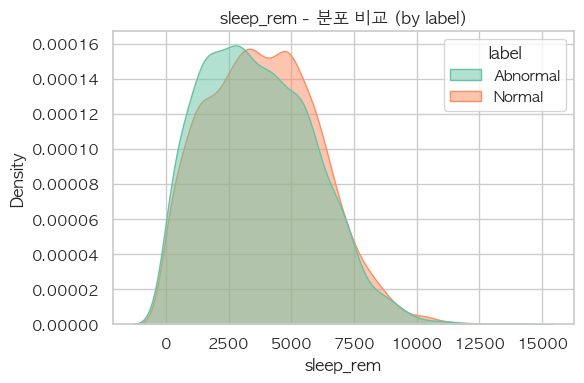

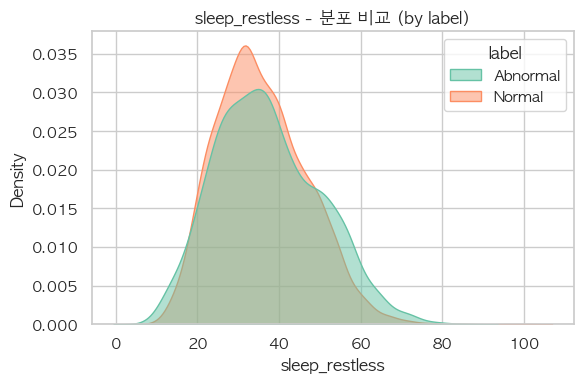

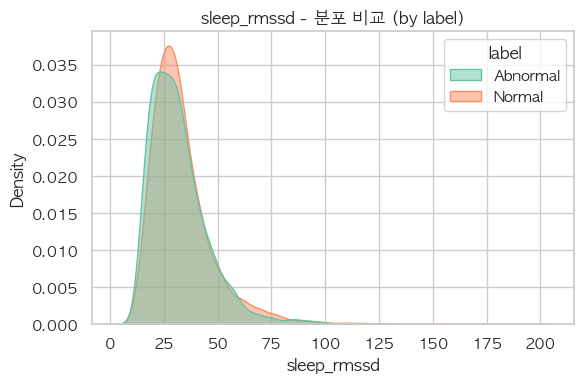

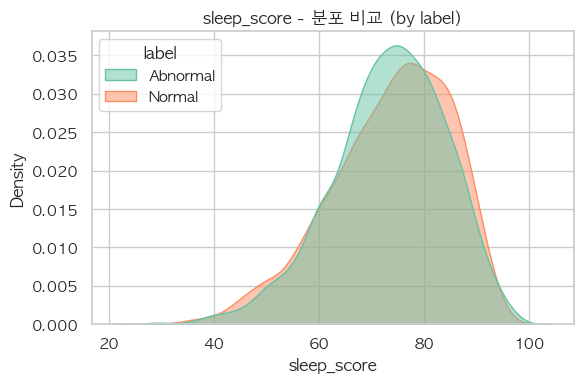

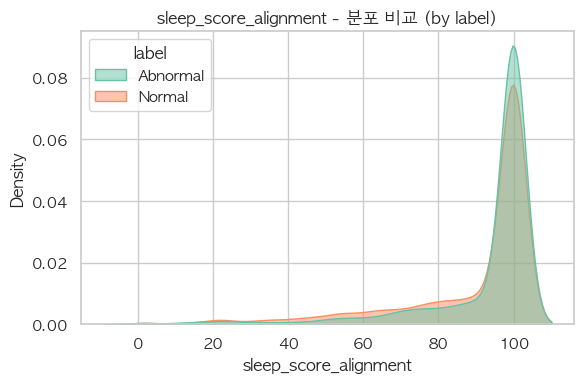

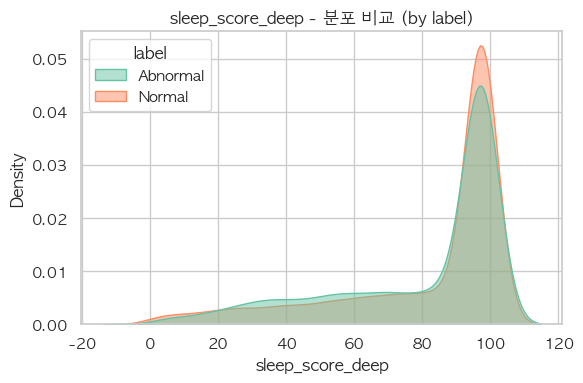

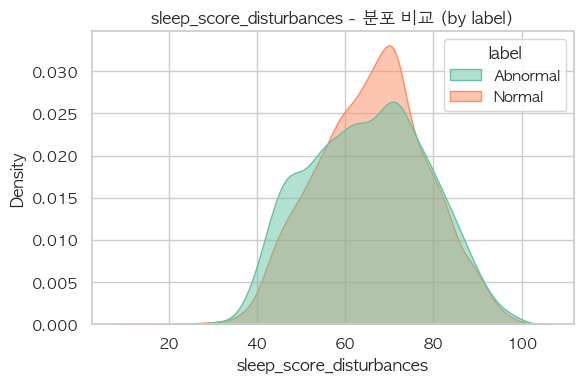

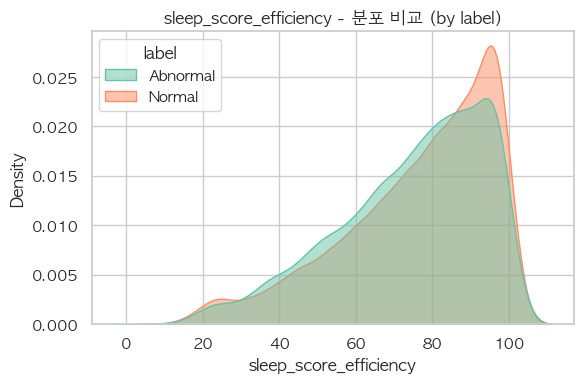

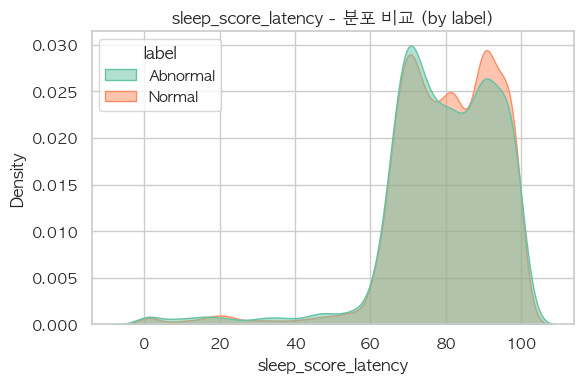

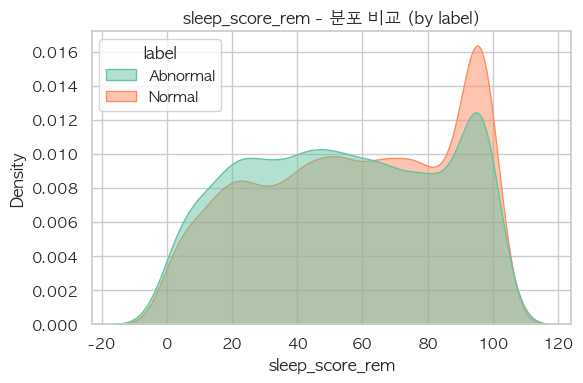

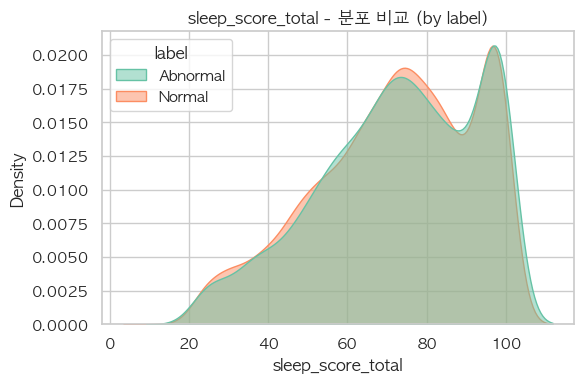

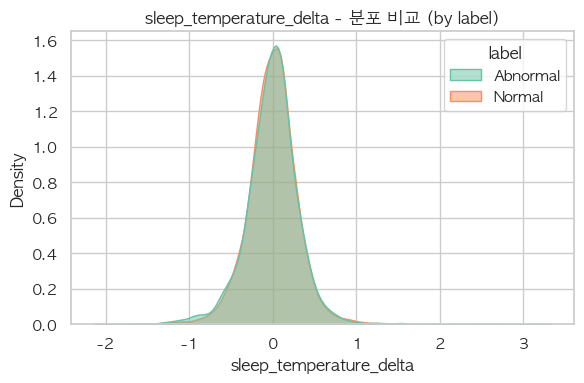

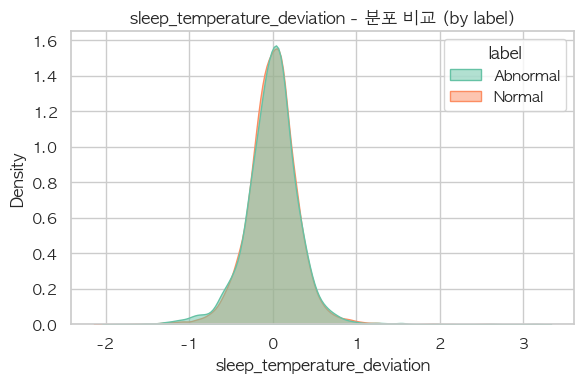

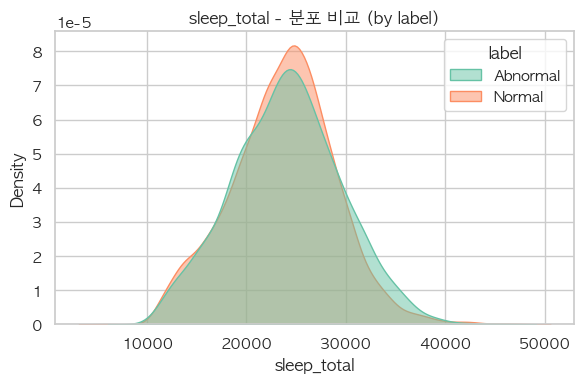

변수명  정규성_p_Normal  정규성_p_Abnormal  MannWhitneyU_p  \
0          sleep_breath_average           0.0             0.0          0.0000   
1                   sleep_awake           0.0             0.0          0.0000   
2                    sleep_deep           0.0             0.0          0.0001   
3                   sleep_light           0.0             0.0          0.0000   
4                sleep_duration           0.0             0.0          0.0000   
5              sleep_efficiency           0.0             0.0          0.0000   
6              sleep_hr_average           0.0             0.0          0.0000   
7               sleep_hr_lowest           0.0             0.0          0.0001   
8              sleep_is_longest           1.0             1.0          1.0000   
9       sleep_midpoint_at_delta           0.0             0.0          0.0000   
10          sleep_midpoint_time           0.0             0.0          0.0000   
11          sleep_onset_latency           0.0             0.0          0.8290   
12              sleep_period_id           0.0             0.0          0.0000   
13                    sleep_rem           0.0             0.0          0.0000   
14               sleep_restless           0.0             0.0          0.0000   
15                  sleep_rmssd           0.0             0.0          0.0000   
16                  sleep_score           0.0             0.0          0.0089   
17        sleep_score_alignment           0.0             0.0          0.0000   
18             sleep_score_deep           0.0             0.0          0.0000   
19     sleep_score_disturbances           0.0             0.0          0.0005   
20       sleep_score_efficiency           0.0             0.0          0.0000   
21          sleep_score_latency           0.0             0.0          0.0239   
22              sleep_score_rem           0.0             0.0          0.0000   
23            sleep_score_total           0.0             0.0          0.0302   
24      sleep_temperature_delta           0.0             0.0          0.6017   
25  sleep_temperature_deviation           0.0             0.0          0.6017   
26                  sleep_total           0.0             0.0          0.0098   

    Normal_중앙값  Abnormal_중앙값  
0        16.88         17.00  
1      4530.00       5010.00  
2      5010.00       4740.00  
3     14460.00      15240.00  
4     28860.00      29460.00  
5        84.00         83.00  
6        60.60         59.72  
7        55.00         54.00  
8         1.00          1.00  
9      9036.50       7595.00  
10    14370.00      14700.00  
11      570.00        570.00  
12        1.00          0.00  
13     3810.00       3480.00  
14       34.00         36.00  
15       30.00         29.00  
16       75.00         74.00  
17      100.00        100.00  
18       96.00         95.00  
19       67.00         65.00  
20       81.00         79.00  
21       81.00         81.00  
22       60.00         54.00  
23       74.00         74.00  
24        0.00          0.00  
25        0.00          0.00  
26    23940.00      24060.00

In [33]:
from scipy.stats import shapiro, mannwhitneyu

# 사용할 수면 관련 변수
sleep_vars = ['sleep_breath_average', 'sleep_awake',
       'sleep_deep', 'sleep_light','sleep_duration', 'sleep_efficiency', 'sleep_hr_average',
       'sleep_hr_lowest', 'sleep_is_longest', 
       'sleep_midpoint_at_delta', 'sleep_midpoint_time', 'sleep_onset_latency',
       'sleep_period_id', 'sleep_rem', 'sleep_restless', 'sleep_rmssd',
       'sleep_score', 'sleep_score_alignment', 'sleep_score_deep',
       'sleep_score_disturbances', 'sleep_score_efficiency',
       'sleep_score_latency', 'sleep_score_rem', 'sleep_score_total',
       'sleep_temperature_delta', 'sleep_temperature_deviation', 'sleep_total',]

# 시각화 + 정규성 + 그룹 차이 통계 분석 함수
def analyze_sleep_variables(df, label_col='label', variables=sleep_vars):
    results = []
    for var in variables:
        # Drop NA
        subset = df[[label_col, var]].dropna()

        # 시각화 (KDE)
        plt.figure(figsize=(6, 4))
        sns.kdeplot(data=subset, x=var, hue=label_col, fill=True, common_norm=False, alpha=0.5)
        plt.title(f"{var} - 분포 비교 (by {label_col})")
        plt.tight_layout()
        plt.show()

        # 정규성 검사 (Shapiro)
        normal_data = subset[subset[label_col] == 'Normal'][var]
        abnormal_data = subset[subset[label_col] == 'Abnormal'][var]
        stat_norm, p_norm = shapiro(normal_data)
        stat_abnorm, p_abnorm = shapiro(abnormal_data)

        # 그룹 차이 유의성 검정 (Mann-Whitney U)
        stat_mw, p_mw = mannwhitneyu(normal_data, abnormal_data, alternative='two-sided')

        results.append({
            '변수명': var,
            '정규성_p_Normal': round(p_norm, 4),
            '정규성_p_Abnormal': round(p_abnorm, 4),
            'MannWhitneyU_p': round(p_mw, 4),
            'Normal_중앙값': round(normal_data.median(), 2),
            'Abnormal_중앙값': round(abnormal_data.median(), 2)
        })

    return pd.DataFrame(results)

# 실행
sleep_stats_df = analyze_sleep_variables(train_daily_df, variables=sleep_vars)
sleep_stats_df


해석 요령
1. 정규성 p-value < 0.05 → 정규분포 아님

→ 그래서 우리는 t-test 대신 Mann–Whitney U test(비모수 검정)를 사용했어

2. Mann-Whitney U p-value < 0.05 → 통계적으로 유의미한 차이

**정규성**, **그룹 간 차이 유의성 (Mann-Whitney U)**, **중앙값 비교**를 기반으로 해석:

---

분석 해석 정리

🔹 1. 그룹 간 **의미 있는 차이**가 있는 변수들 (p < 0.05)

| 변수명 | Normal > Abnormal | Abnormal > Normal | 해석 요약 |
|--------|-------------------|-------------------|-----------|
| **sleep_breath_average** | 16.88 vs 17.00 | ✅ | Abnormal 그룹의 호흡수 더 높음 (미세하지만 유의미) |
| **sleep_awake** | 4530 vs 5010 | ✅ | 비정상군에서 **잠에서 더 자주 깸** |
| **sleep_deep** | ✅ | | 정상군이 더 깊은 수면 |
| **sleep_light** | | ✅ | 비정상군이 얕은 수면이 많음 |
| **sleep_duration** | | ✅ | 수면 시간 더 긺 |
| **sleep_efficiency** | ✅ | | 정상군이 수면 효율 더 좋음 |
| **sleep_hr_average** | ✅ | | 평균 심박수 낮음 (Abnormal) → 심리적 안정? |
| **sleep_hr_lowest** | ✅ | | 최저 심박수도 낮음 (Abnormal) |
| **sleep_midpoint_at_delta** | ✅ | | 정상군 수면 중간 지점이 더 늦음 |
| **sleep_midpoint_time** | | ✅ | 비정상군 수면 중간 시각이 더 늦음 |
| **sleep_period_id** | ✅ | | 정상군에서 '가장 긴 수면'으로 인식된 경우 더 많음 |
| **sleep_rem** | ✅ | | 정상군이 REM 수면 많음 |
| **sleep_restless** | | ✅ | 비정상군이 뒤척임 많음 |
| **sleep_rmssd** | ✅ | | 정상군이 HRV 높음 (스트레스 ↓) |
| **sleep_score_total** | ✅ | | 전반적 수면 점수 차이 |
| **sleep_score_deep** | ✅ | | 깊은 수면 점수 차이 |
| **sleep_score_disturbances** | ✅ | | 정상군이 방해 적음 |
| **sleep_score_efficiency** | ✅ | | 정상군 수면 효율 더 높음 |
| **sleep_score_latency** | ❌ | ❌ | p는 유의하지만 중앙값 차이 없음 |
| **sleep_score_rem** | ✅ | | REM 수면 점수 차이 |

---

2. 그룹 간 **차이 없음 (p ≥ 0.05)**

| 변수명 | 해석 |
|--------|------|
| **sleep_onset_latency** | 잠드는 데 걸린 시간은 차이 없음 |
| **sleep_score_alignment** | 수면 리듬 정렬 점수는 동일 |
| **sleep_temperature_delta** / **deviation** | 체온 변화 차이 없음 |
| **sleep_is_longest** | 모두 가장 긴 수면으로 판단 (변별력 없음) |

---

핵심 인사이트 요약

**정상 그룹의 특징**:
- 더 깊고 효율적인 수면  
- 더 적은 각성, 뒤척임, 방해  
- 더 높은 HRV (스트레스 낮음), 더 많은 REM

**비정상 그룹의 특징**:
- 얕은 수면 + 각성 많음  
- 수면 시간은 오히려 길어짐 (보상적 수면 가능성)  
- 수면 중간 시점이 늦고 리듬이 흐트러질 가능성

---

다음 액션 제안

- ✅ 중요한 수면 변수 shortlist:  
  `sleep_duration`, `sleep_efficiency`, `sleep_rmssd`, `sleep_rem`, `sleep_score_efficiency`, `sleep_restless`

- 이 변수들로 feature selection 해도 좋고  
- 이상치 제외 후 모델 학습 전용으로 파생 변수(예: 수면 안정성 점수)를 만들어도 좋아

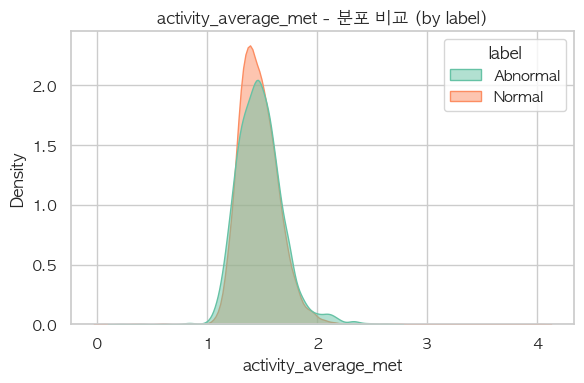

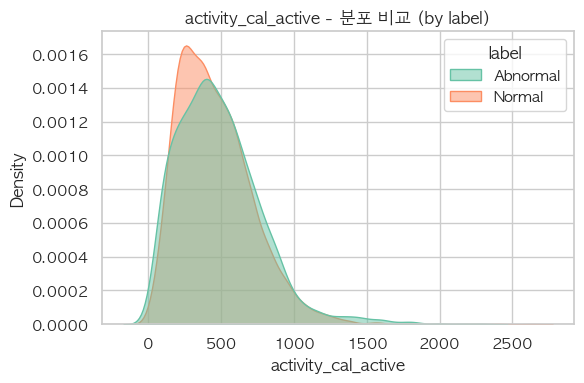

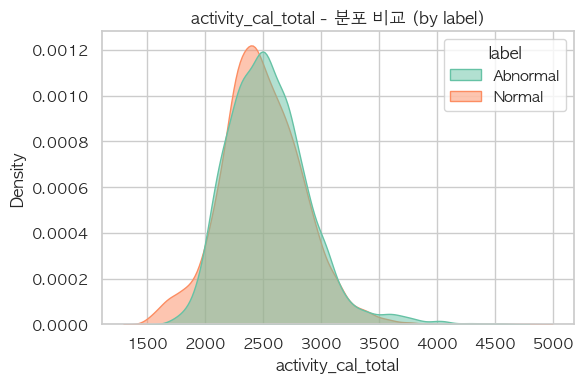

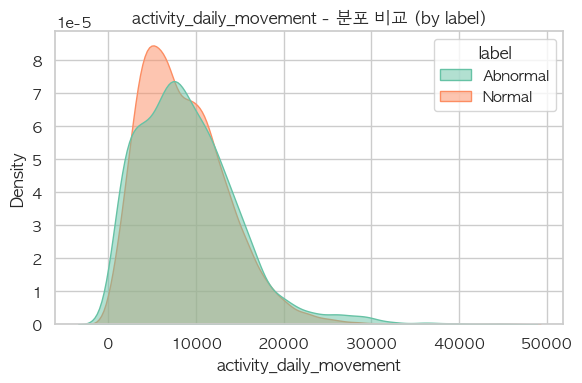

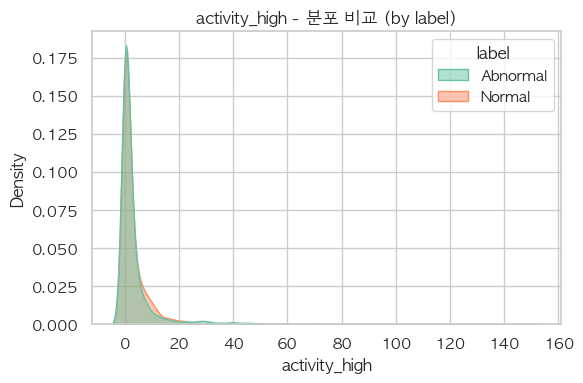

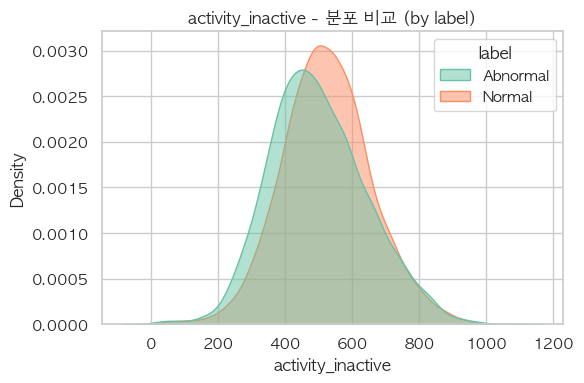

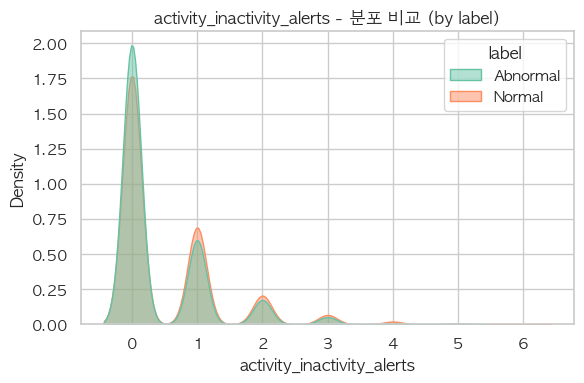

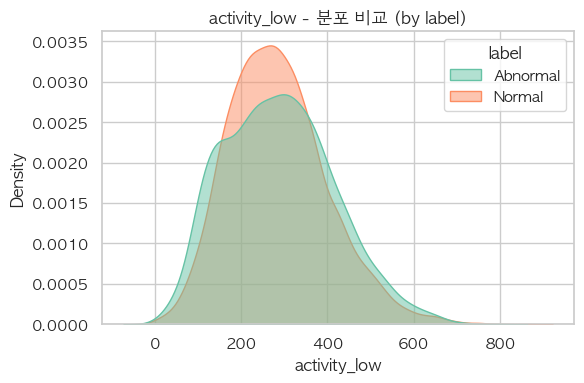

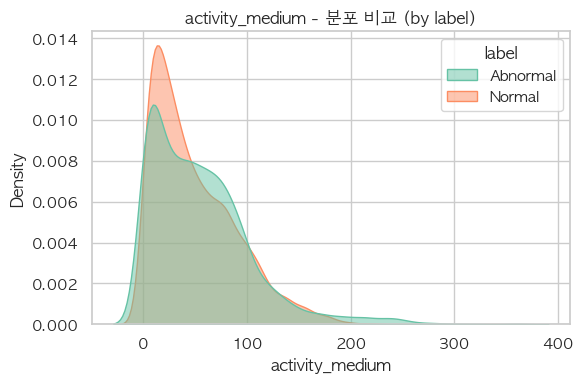

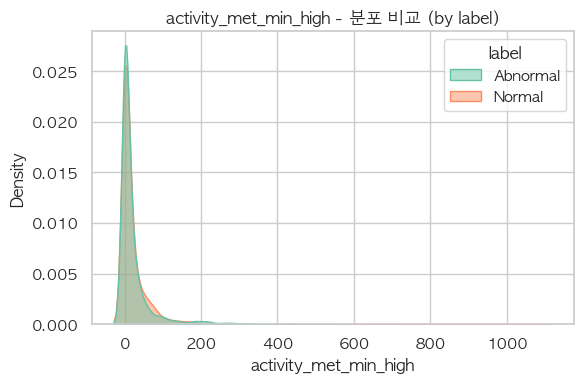

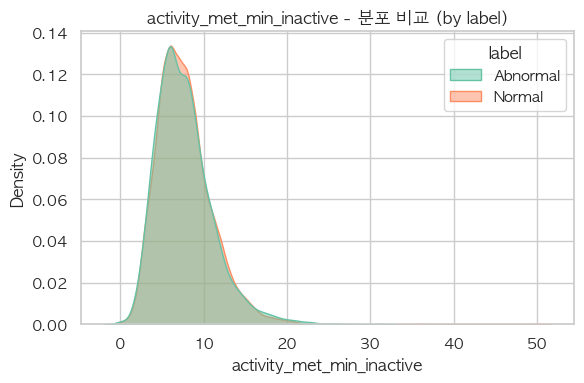

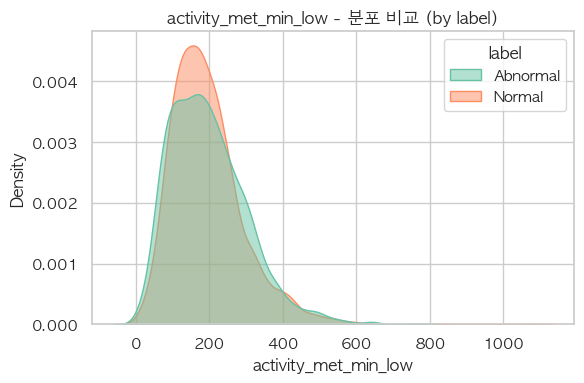

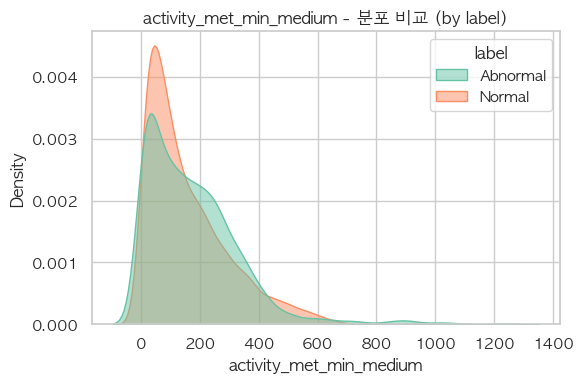

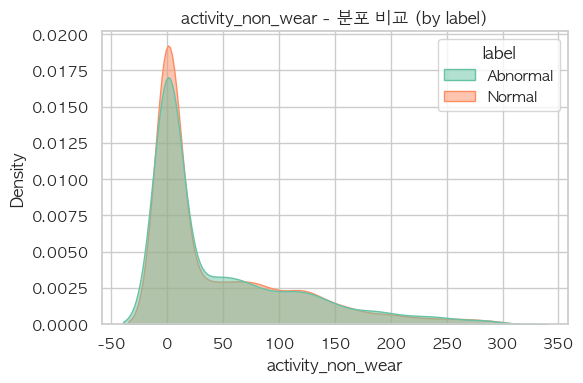

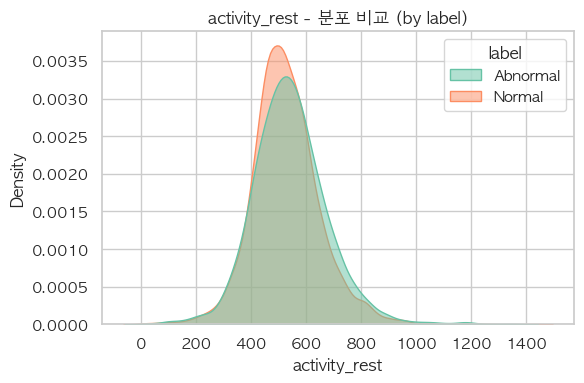

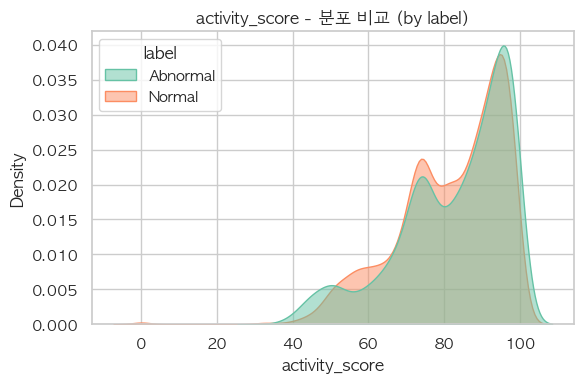

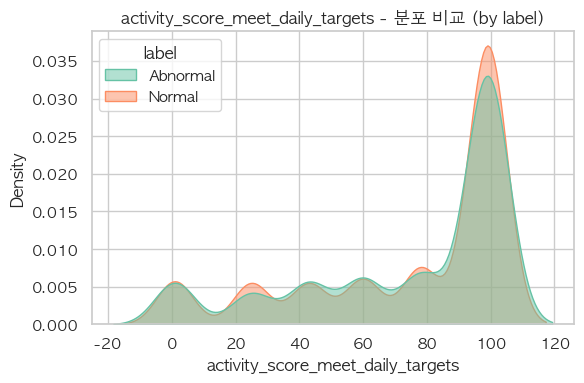

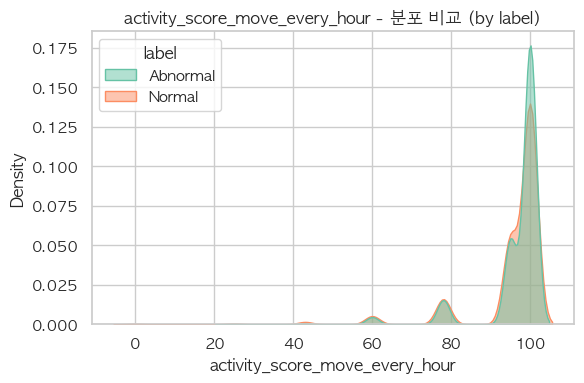

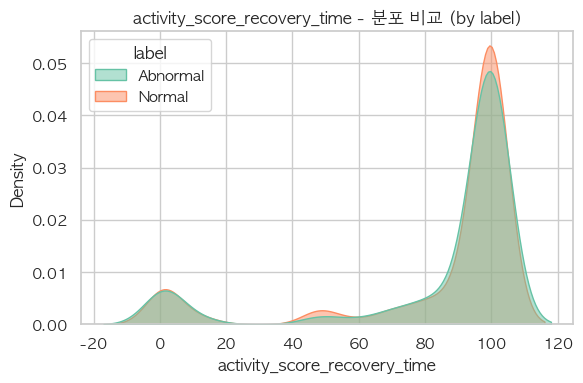

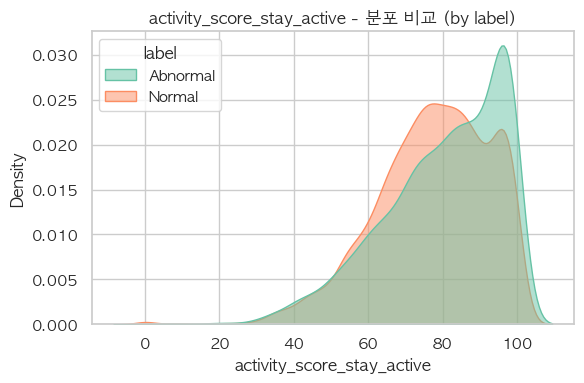

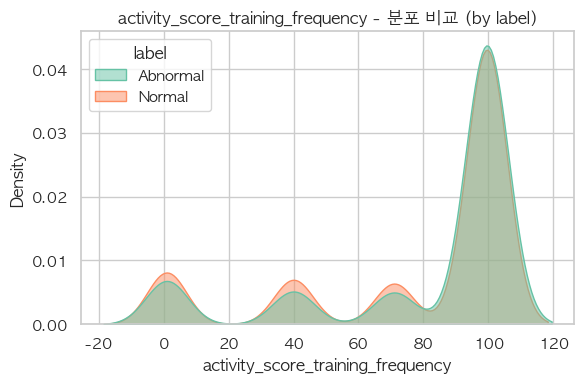

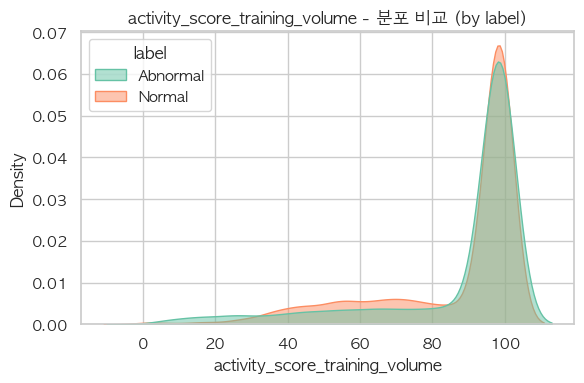

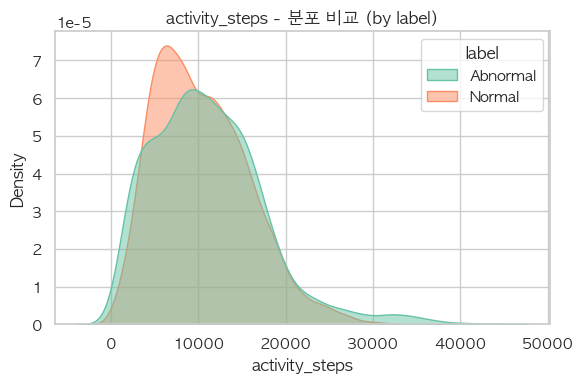

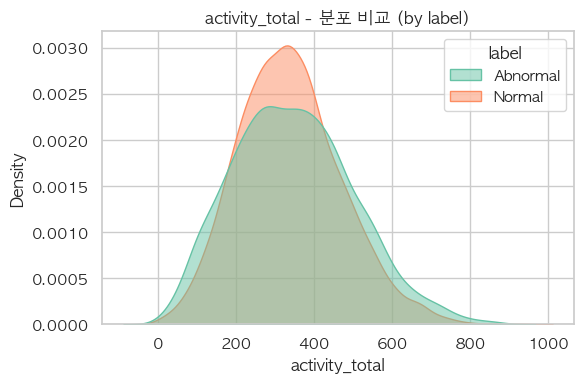

변수명  정규성_p_Normal  정규성_p_Abnormal  \
0                activity_average_met           0.0             0.0   
1                 activity_cal_active           0.0             0.0   
2                  activity_cal_total           0.0             0.0   
3             activity_daily_movement           0.0             0.0   
4                       activity_high           0.0             0.0   
5                   activity_inactive           0.0             0.0   
6          activity_inactivity_alerts           0.0             0.0   
7                        activity_low           0.0             0.0   
8                     activity_medium           0.0             0.0   
9               activity_met_min_high           0.0             0.0   
10          activity_met_min_inactive           0.0             0.0   
11               activity_met_min_low           0.0             0.0   
12            activity_met_min_medium           0.0             0.0   
13                  activity_non_wear           0.0             0.0   
14                      activity_rest           0.0             0.0   
15                     activity_score           0.0             0.0   
16  activity_score_meet_daily_targets           0.0             0.0   
17     activity_score_move_every_hour           0.0             0.0   
18       activity_score_recovery_time           0.0             0.0   
19         activity_score_stay_active           0.0             0.0   
20  activity_score_training_frequency           0.0             0.0   
21     activity_score_training_volume           0.0             0.0   
22                     activity_steps           0.0             0.0   
23                     activity_total           0.0             0.0   

    MannWhitneyU_p  Normal_중앙값  Abnormal_중앙값  
0           0.0456        1.44          1.47  
1           0.0004      418.00        446.00  
2           0.0000     2463.00       2508.00  
3           0.0146     7900.50       8369.00  
4           0.0001        1.00          1.00  
5           0.0000      521.00        485.00  
6           0.0000        0.00          0.00  
7           0.2320      275.00        284.00  
8           0.0009       39.00         47.00  
9           0.0008        7.00          5.00  
10          0.3527        7.00          7.00  
11          0.4122      179.00        184.00  
12          0.0000      115.00        145.00  
13          0.8757        1.00          0.00  
14          0.0000      517.00        535.00  
15          0.0000       84.00         87.00  
16          0.4029       95.00         95.00  
17          0.0000      100.00        100.00  
18          0.2405      100.00        100.00  
19          0.0000       79.00         83.00  
20          0.0000      100.00        100.00  
21          0.0000       97.00         97.00  
22          0.0002     9743.50      10472.00  
23          0.0243      330.00        339.00

In [34]:
activity_vars = ['activity_average_met', 'activity_cal_active',
       'activity_cal_total', 'activity_daily_movement', 'activity_high', 'activity_inactive',
       'activity_inactivity_alerts', 'activity_low', 'activity_medium',
       'activity_met_min_high', 'activity_met_min_inactive',
       'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear',
       'activity_rest', 'activity_score', 'activity_score_meet_daily_targets',
       'activity_score_move_every_hour', 'activity_score_recovery_time',
       'activity_score_stay_active', 'activity_score_training_frequency',
       'activity_score_training_volume', 'activity_steps', 'activity_total']
activity_stats_df = analyze_sleep_variables(train_daily_df, variables=activity_vars)
activity_stats_df

🔹 유의미한 차이 있음 (p < 0.05)

| 변수명 | Normal | Abnormal | 해석 |
|--------|--------|----------|------|
| **activity_average_met** | 1.44 | 1.47 | Abnormal 그룹이 **조금 더 높은 MET 평균** → 활동 세기 조금 강함 |
| **activity_cal_active** | 418 | 446 | ✅ 비정상군의 **활동 칼로리 소모량 더 많음** |
| **activity_cal_total** | 2463 | 2508 | ✅ 비정상군의 **총 칼로리 소모량 더 많음** |
| **activity_daily_movement** | 7900 | 8369 | ✅ 비정상군이 **더 많이 움직임** |
| **activity_inactive** | 521 | 485 | ✅ 정상군이 **더 오래 비활동 상태** (역설적!) |
| **activity_medium** | 39 | 47 | ✅ Abnormal 그룹의 **중강도 활동 시간 많음** |
| **activity_met_min_high** | 7 | 5 | ✅ 정상군의 **고강도 MET 더 많음** (강하게 짧게?) |
| **activity_met_min_medium** | 115 | 145 | ✅ 비정상군의 **중강도 MET 더 많음** |
| **activity_rest** | 517 | 535 | ✅ 비정상군이 **더 오래 쉬었음** (non-wear 제외 활동 외 휴식?) |
| **activity_score** | 84 | 87 | ✅ 비정상군이 활동 점수 더 높음 |
| **activity_score_move_every_hour** | 100 | 100 | p < 0.05지만 **중앙값 같음 → 분포만 다름** |
| **activity_score_stay_active** | 79 | 83 | ✅ 비정상군이 **지속적인 활동 점수 더 좋음** |
| **activity_score_training_frequency** | 100 | 100 | ✅ 분포 차이 존재 (중앙값은 같음) |
| **activity_score_training_volume** | 97 | 97 | ✅ 분포 차이 존재 |
| **activity_steps** | 9743 | 10472 | ✅ 비정상군이 **하루 걸음 수 더 많음** |
| **activity_total** | 330 | 339 | ✅ 비정상군의 **활동 총 시간(분)** 더 김

---

🔹 유의미한 차이 없음 (p ≥ 0.05)

| 변수명 | 해석 |
|--------|------|
| **activity_low**, **met_min_low**, **met_min_inactive** | 활동 수준 낮은 영역에서는 유의미한 차이 없음 |
| **activity_non_wear** | 착용 여부 차이 없음 |
| **activity_inactivity_alerts** | 둘 다 거의 없음 |
| **activity_score_meet_daily_targets**, **recovery_time** | 활동 목표/회복 점수는 차이 없음 |

---

🔍 전체 해석 요약

- **비정상군(Abnormal)**이 전반적으로:
  - **더 많이 움직이고**  
  - **칼로리를 더 많이 소모하고**  
  - **중강도 활동을 더 많이 함**
  - → 하지만 동시에 **휴식 시간도 조금 더 김**

- **정상군(Normal)**은:
  - **고강도 활동량**은 조금 더 많고  
  - **비활동 시간도 더 많음** (낮잠, 앉아있는 시간?)

---

📌 인사이트

- 치매 위험군이 오히려 더 **움직임 많고 활동 점수도 높은 경향**  
→ "활동량이 많다고 해서 꼭 정상은 아니다"  
→ 활동의 **질적 구성**(MET 분포, 리듬 등)이 중요할 수도

좋아! `train_daily_df`는 하루 단위 데이터니까  
`시간 흐름에 따라 수면/활동/인지 기능이 어떻게 변화하는지`를 분석하기에 딱이야 ⏳📈

---

✅ 시간에 따른 변화 분석 – 계획

1. 📅 기준 날짜 만들기
- `activity_day_start`나 `sleep_bedtime_start`에서 `.dt.date`로 날짜 추출
- 또는 일 단위 index 생성

2. 📊 전체 평균 변화
- `label`별 또는 전체 데이터에서 시간별 **평균값 변화 추이**

3. 🧍‍♂️ 개인별 변화
- 사람(EMAIL) 단위로 **MMSE 점수나 수면 변수 변화** 확인
- “누가 점점 더 나빠지거나 좋아지는가?”

4. 📉 변화율(Δ) 계산
- 예: 3일 이동평균, 변화폭(diff), 누적합(cumsum) 등

---

⏳ 추가로 할 수 있는 분석

| 유형 | 예시 |
|------|------|
| 📆 일/주 단위 변화 | 하루 평균 걸음 수, 수면 효율 등 |
| 📈 추세선 fitting | 이동평균(SMA), 선형 회귀선 |
| 👤 사용자별 패턴 | 개인별 수면 변화 or MMSE 변화 |

---

바로 해볼까?  
- 전체 그룹별 추이 볼래?  
- 사람별로 줄여서 한두 명만 시간 흐름 분석해볼까?  
- 수면 점수, 활동 점수, mmse 중 어떤 걸 볼까? 😎

<Axes: xlabel='date', ylabel='sleep_score_total'>

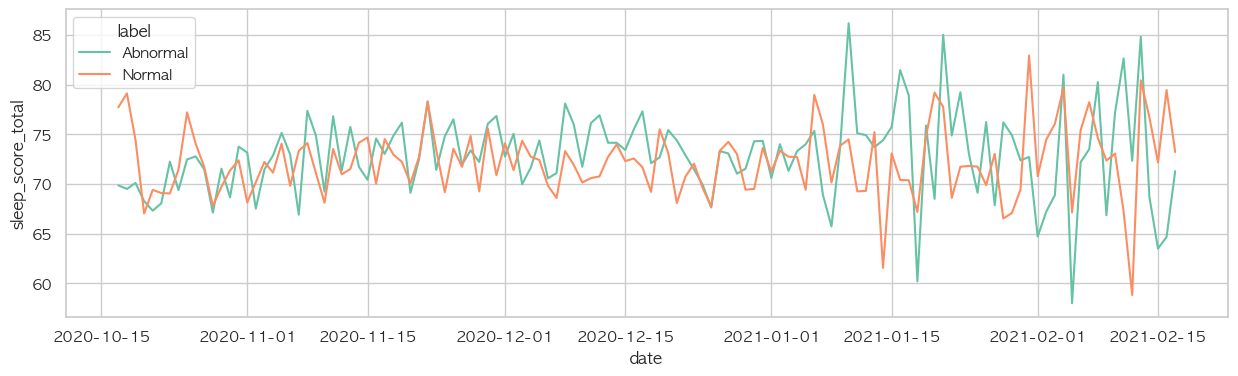

In [35]:
train_daily_df["date"] = pd.to_datetime(train_daily_df["activity_day_start"]).dt.date

# 그룹별, 날짜별 평균 sleep_score_total
sleep_score_by_date = train_daily_df.groupby(["date", "label"])["sleep_score_total"].mean().reset_index()

# 시각화
plt.figure(figsize=(15, 4))
sns.lineplot(data=sleep_score_by_date, x="date", y="sleep_score_total", hue="label")

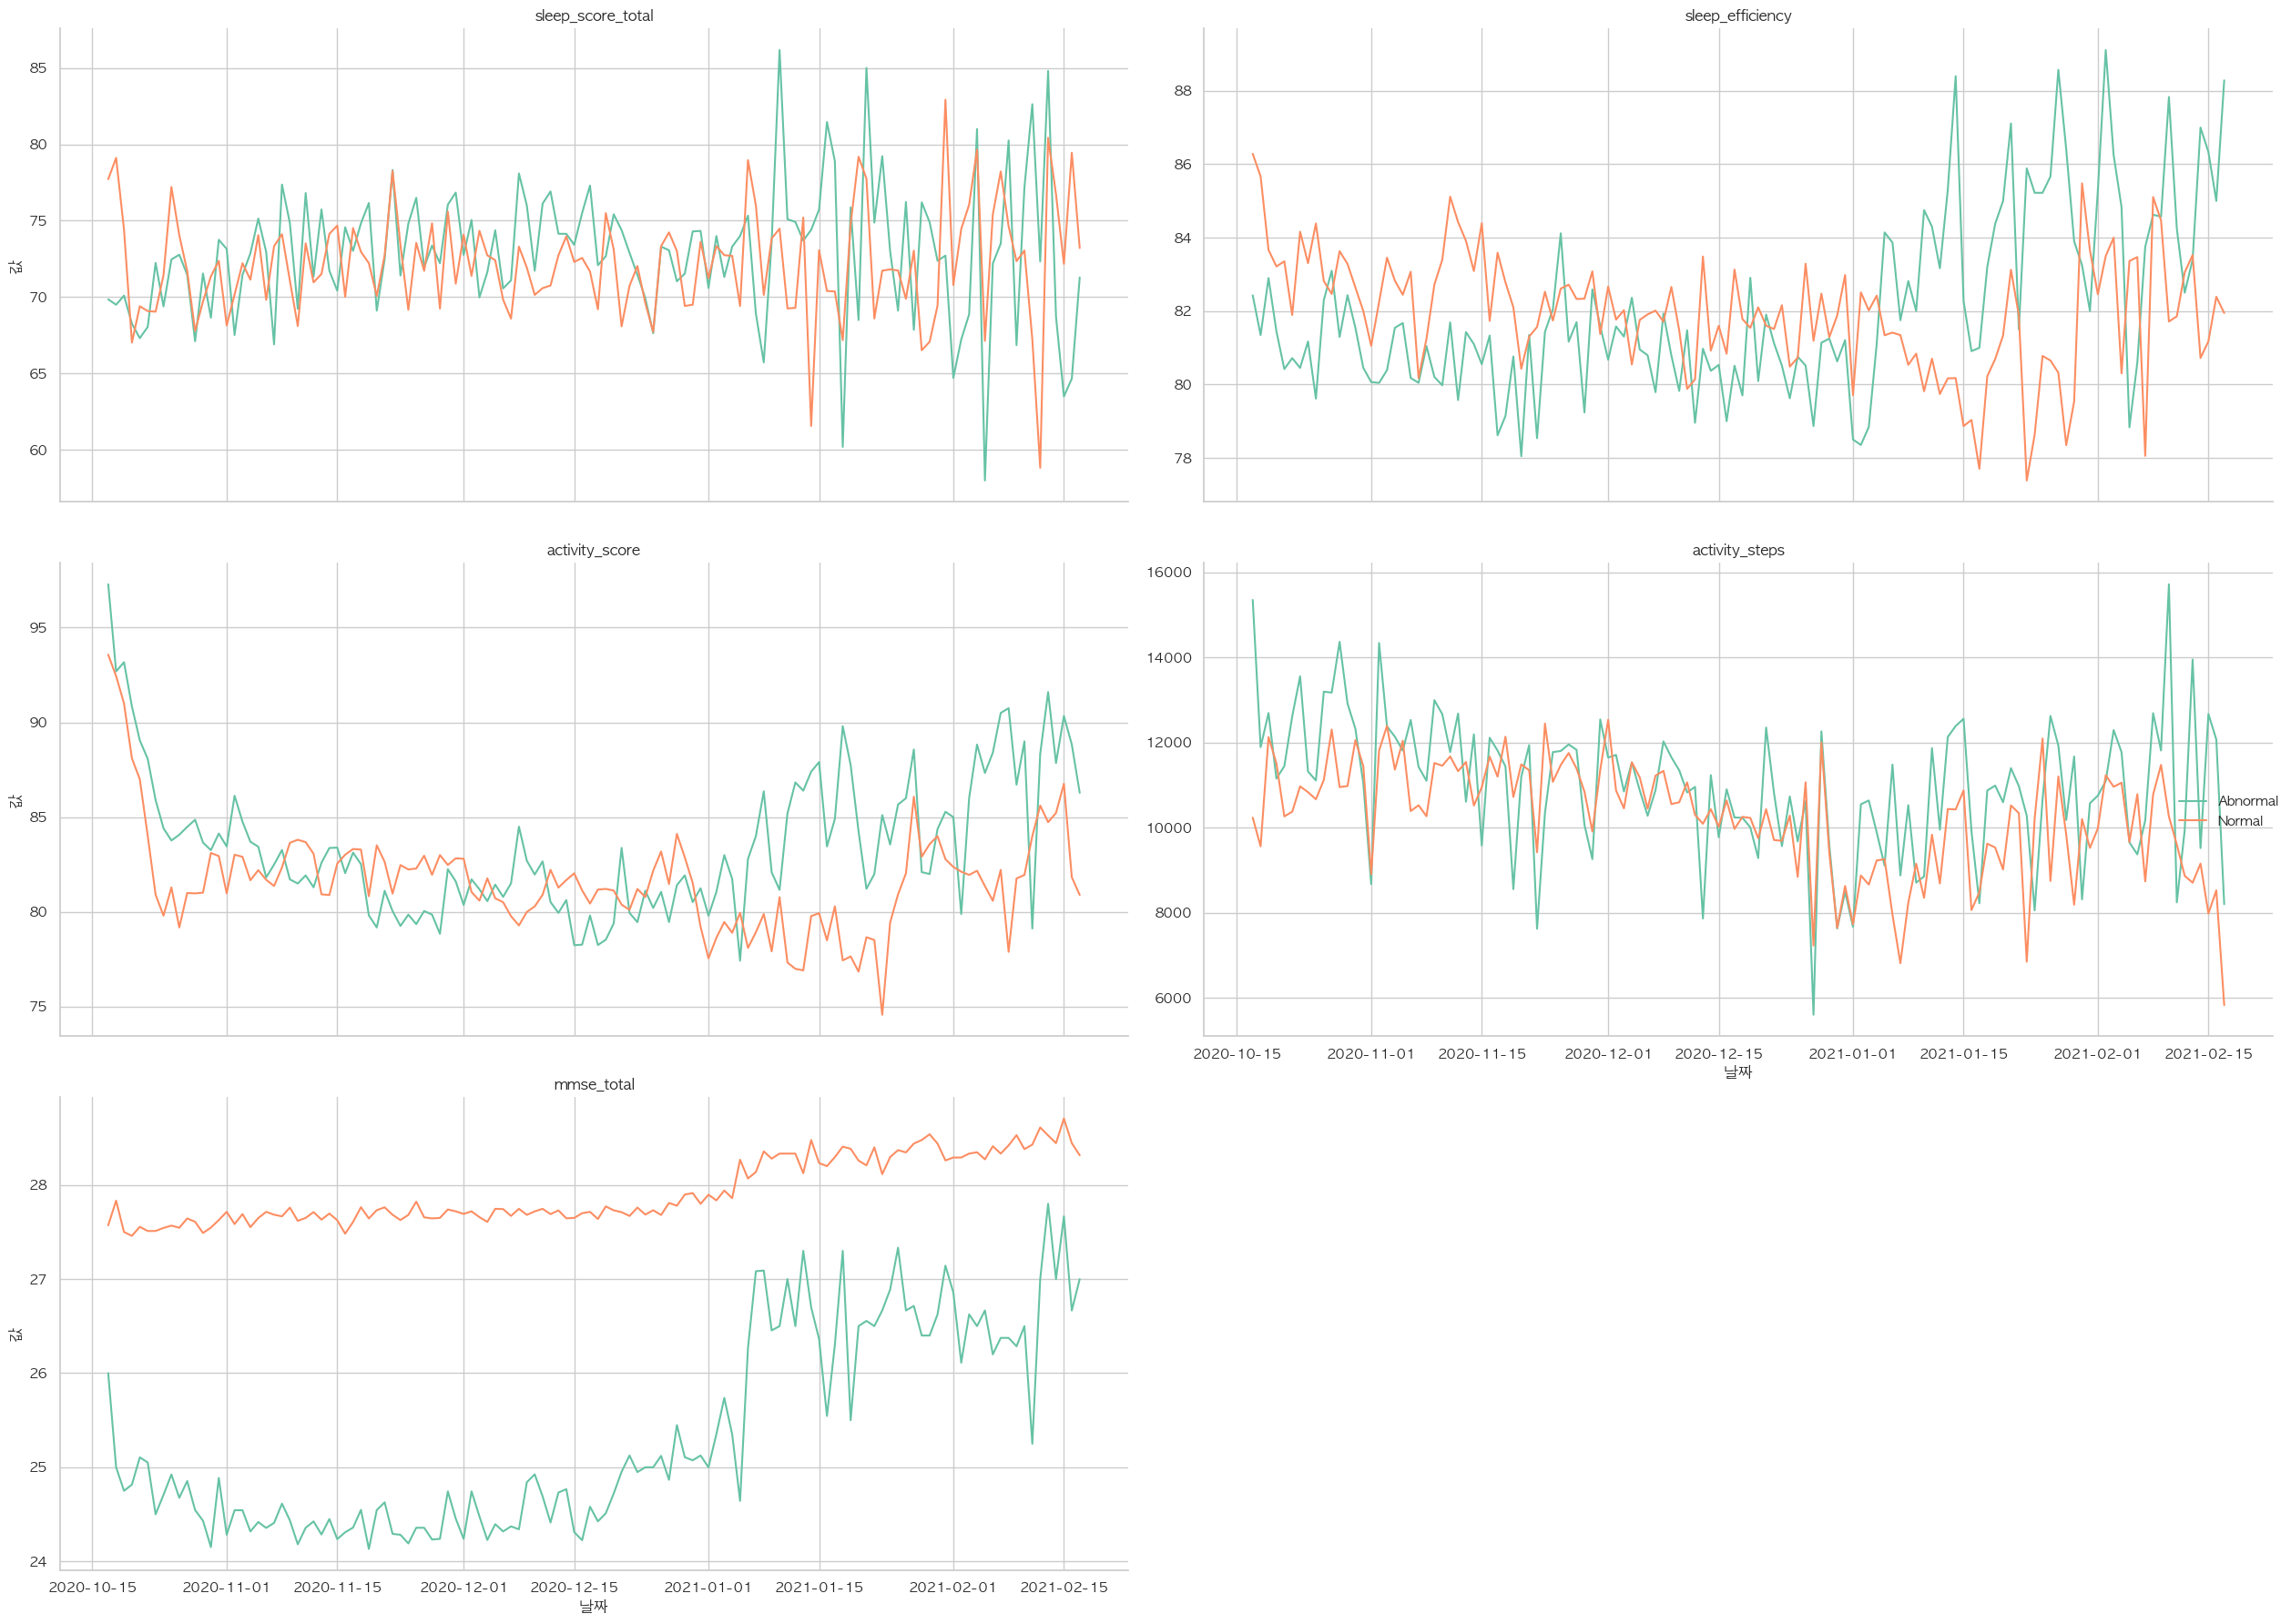

In [36]:
# 날짜 컬럼 생성
train_daily_df["date"] = pd.to_datetime(train_daily_df["activity_day_start"]).dt.date

# 수면 및 활동 관련 주요 변수 중에서 시간 흐름을 볼 예시 변수
time_series_vars = [
    "sleep_score_total", "sleep_efficiency",
    "activity_score", "activity_steps",
    "mmse_total"
]

# 변수별 평균값을 날짜 + label 기준으로 계산
time_series_df = (
    train_daily_df.groupby(["date", "label"])[time_series_vars]
    .mean()
    .reset_index()
    .melt(id_vars=["date", "label"], var_name="변수", value_name="값")
)

# 시각화
g = sns.FacetGrid(time_series_df, col="변수", col_wrap=2, height=6, aspect=2, sharey=False)
g.map_dataframe(sns.lineplot, x="date", y="값", hue="label")
g.set_titles("{col_name}")
g.set_axis_labels("날짜", "값")
g.add_legend()
plt.tight_layout()
plt.show()


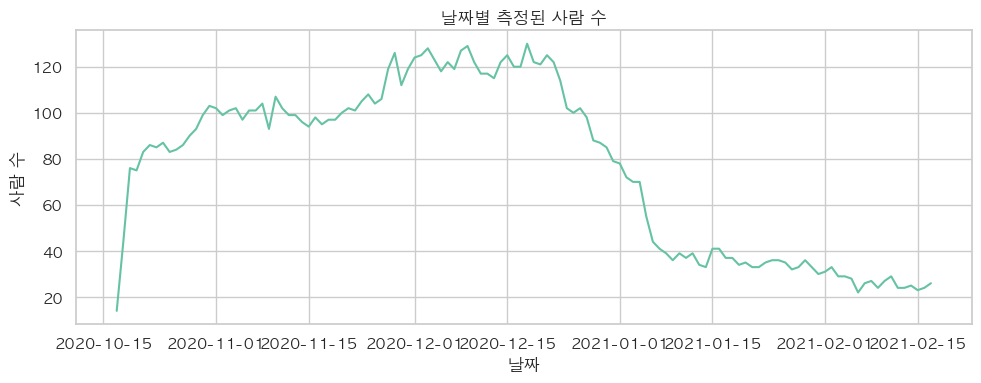

In [37]:
sample_counts = train_daily_df.groupby("date")["EMAIL"].nunique()

plt.figure(figsize=(10, 4))
sns.lineplot(x=sample_counts.index, y=sample_counts.values)
plt.title("날짜별 측정된 사람 수")
plt.ylabel("사람 수")
plt.xlabel("날짜")
plt.tight_layout()
plt.show()

- 간 흐름을 보면 사람 수가 점점 줄어들어서 왜곡이 생길 수 있음

따라서 ,측정 시작일로부터 경과일(day since start)을 기준으로 정렬해서
시간 흐름에 따른 변화를 분석해보자

<Axes: xlabel='days_since_start', ylabel='sleep_score_total'>

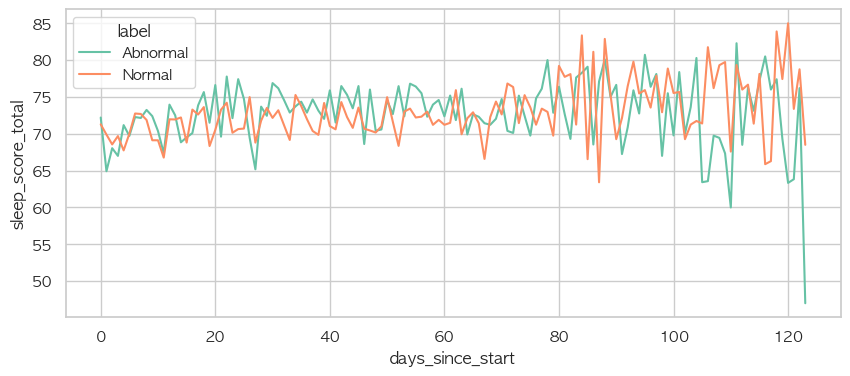

In [38]:
train_daily_df["activity_day_start"] = pd.to_datetime(train_daily_df["activity_day_start"])
train_daily_df["start_date_per_person"] = train_daily_df.groupby("EMAIL")["activity_day_start"].transform("min")
# 경과일수 = 활동 날짜 - 개인 시작 날짜
train_daily_df["days_since_start"] = (
    (train_daily_df["activity_day_start"] - train_daily_df["start_date_per_person"]).dt.days
)

df_grouped = train_daily_df.groupby(["days_since_start", "label"])[["sleep_score_total", "mmse_total"]].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_grouped, x="days_since_start", y="sleep_score_total", hue="label")


In [39]:
train_daily_df.groupby('EMAIL').count().describe()

activity_average_met  activity_cal_active  activity_cal_total  \
count            137.000000           137.000000          137.000000   
mean              69.759124            69.759124           69.759124   
std               20.120053            20.120053           20.120053   
min               35.000000            35.000000           35.000000   
25%               58.000000            58.000000           58.000000   
50%               66.000000            66.000000           66.000000   
75%               79.000000            79.000000           79.000000   
max              122.000000           122.000000          122.000000   

       activity_daily_movement  activity_day_end  activity_day_start  \
count               137.000000        137.000000          137.000000   
mean                 69.759124         69.759124           69.759124   
std                  20.120053         20.120053           20.120053   
min                  35.000000         35.000000           35.000000   
25%                  58.000000         58.000000           58.000000   
50%                  66.000000         66.000000           66.000000   
75%                  79.000000         79.000000           79.000000   
max                 122.000000        122.000000          122.000000   

       activity_high  activity_inactive  activity_inactivity_alerts  \
count     137.000000         137.000000                  137.000000   
mean       69.759124          69.759124                   69.759124   
std        20.120053          20.120053                   20.120053   
min        35.000000          35.000000                   35.000000   
25%        58.000000          58.000000                   58.000000   
50%        66.000000          66.000000                   66.000000   
75%        79.000000          79.000000                   79.000000   
max       122.000000         122.000000                  122.000000   

       activity_low  ...  paper_return   draw_star  read_sentence  \
count    137.000000  ...    137.000000  137.000000     137.000000   
mean      69.759124  ...     69.759124   69.759124      69.759124   
std       20.120053  ...     20.120053   20.120053      20.120053   
min       35.000000  ...     35.000000   35.000000      35.000000   
25%       58.000000  ...     58.000000   58.000000      58.000000   
50%       66.000000  ...     66.000000   66.000000      66.000000   
75%       79.000000  ...     79.000000   79.000000      79.000000   
max      122.000000  ...    122.000000  122.000000     122.000000   

       write_sentence  mmse_total     DIAG_NM       label        date  \
count      137.000000  137.000000  137.000000  137.000000  137.000000   
mean        69.759124   69.759124   69.759124   69.759124   69.759124   
std         20.120053   20.120053   20.120053   20.120053   20.120053   
min         35.000000   35.000000   35.000000   35.000000   35.000000   
25%         58.000000   58.000000   58.000000   58.000000   58.000000   
50%         66.000000   66.000000   66.000000   66.000000   66.000000   
75%         79.000000   79.000000   79.000000   79.000000   79.000000   
max        122.000000  122.000000  122.000000  122.000000  122.000000   

       start_date_per_person  days_since_start  
count             137.000000        137.000000  
mean               69.759124         69.759124  
std                20.120053         20.120053  
min                35.000000         35.000000  
25%                58.000000         58.000000  
50%                66.000000         66.000000  
75%                79.000000         79.000000  
max               122.000000        122.000000  

[8 rows x 100 columns]

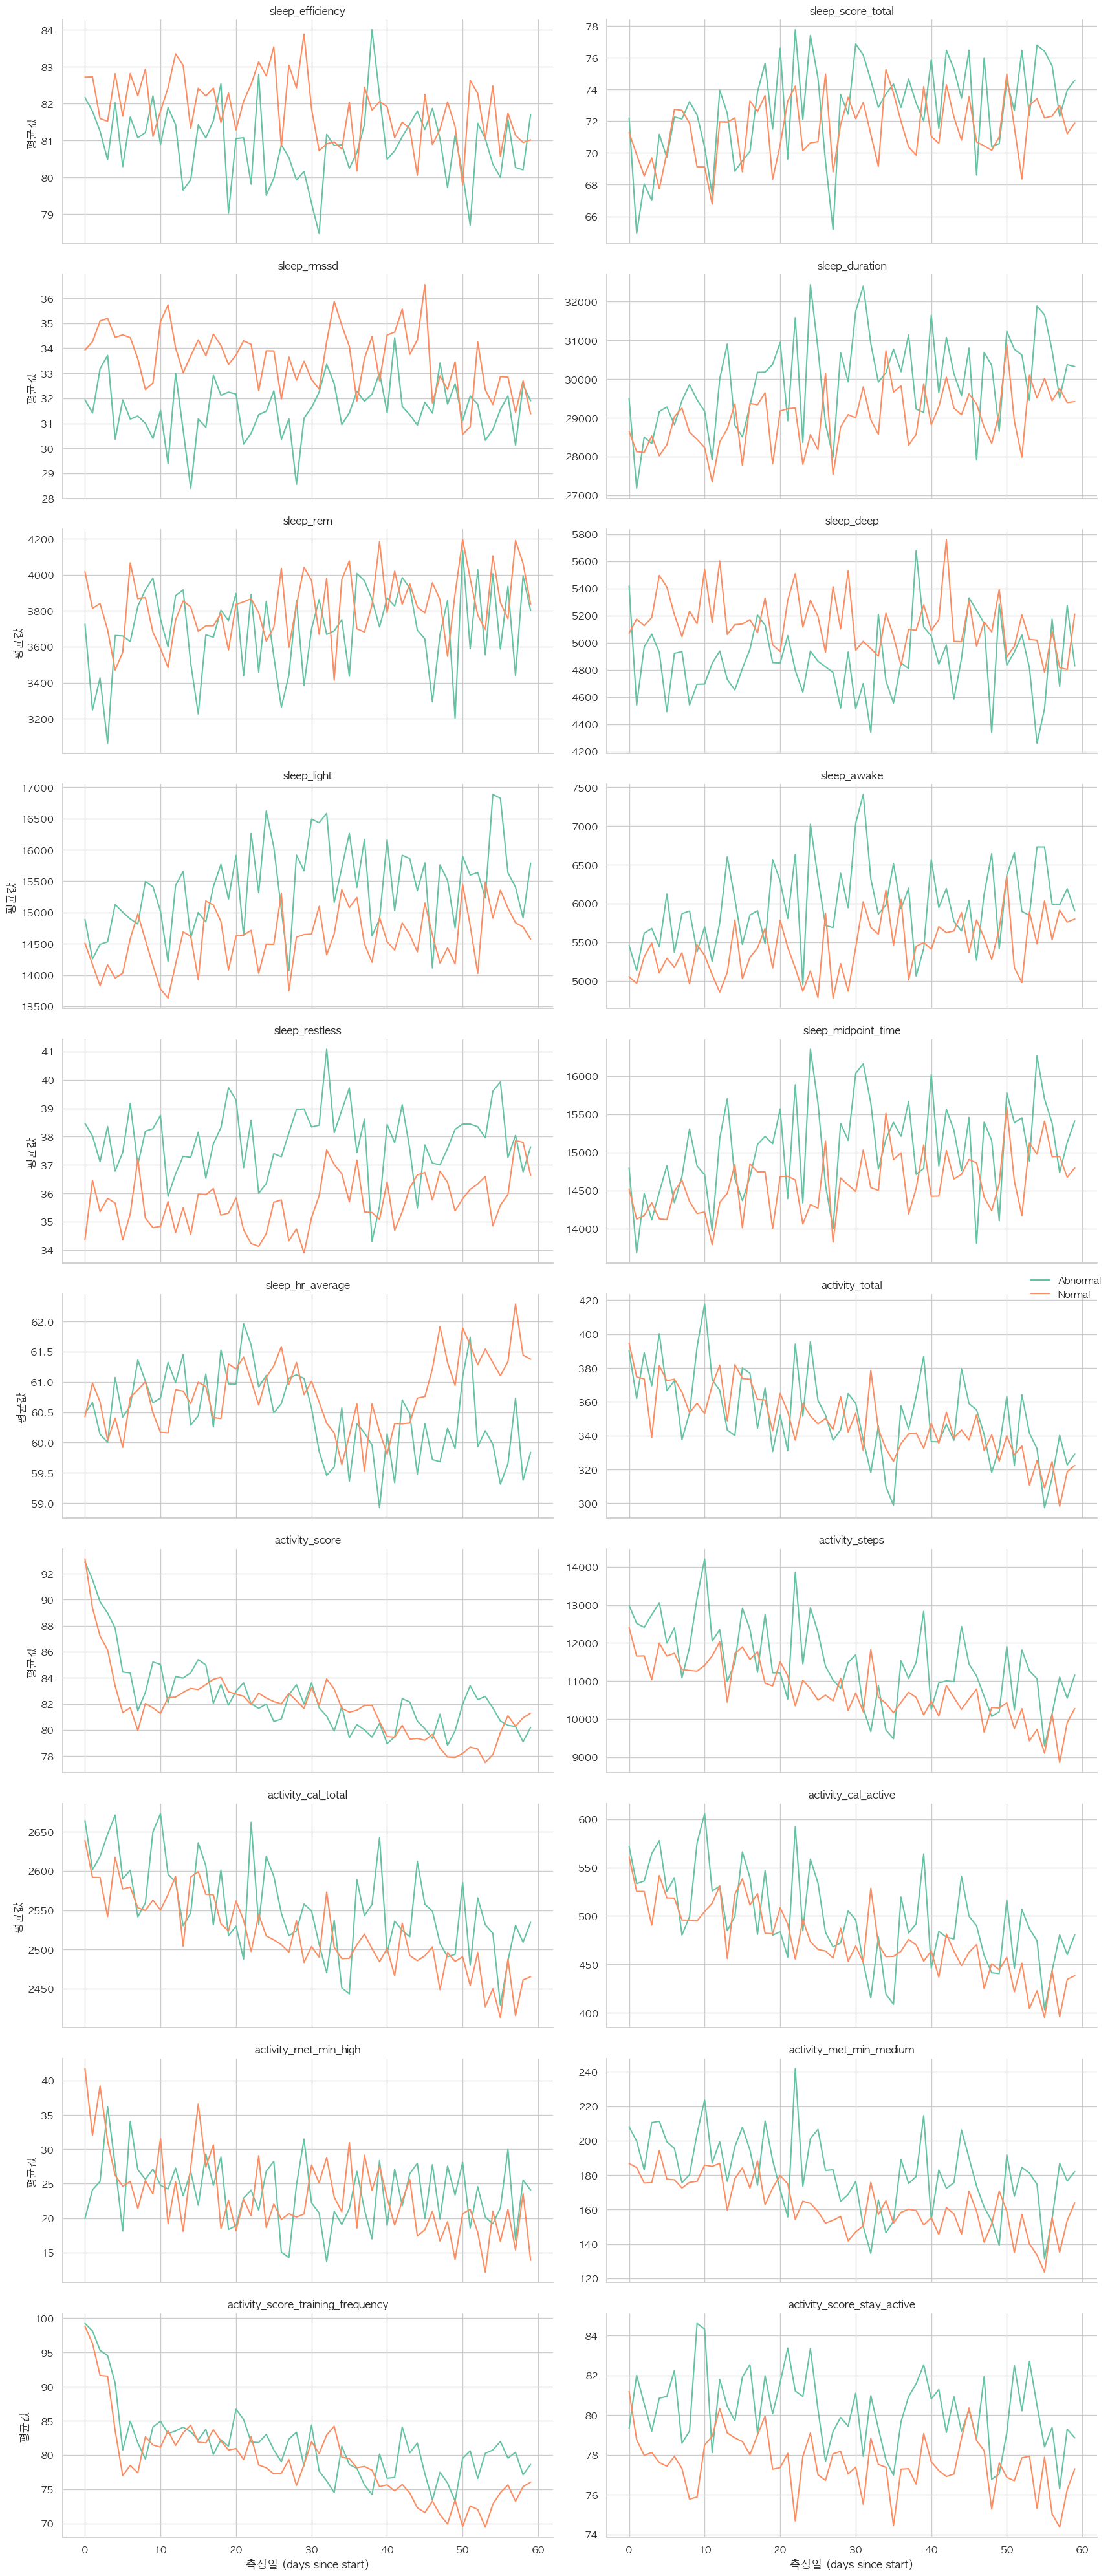

In [40]:
# 시각화할 변수 리스트
selected_vars  = ['sleep_efficiency', 'sleep_score_total', 'sleep_rmssd', 'sleep_duration',
        'sleep_rem', 'sleep_deep', 'sleep_light', 'sleep_awake', 'sleep_restless', 
        'sleep_midpoint_time', 'sleep_hr_average', 'sleep_rmssd',
        'activity_total', 'activity_score', 'activity_steps', 
        'activity_cal_total', 'activity_cal_active', 'activity_met_min_high', 'activity_met_min_medium',
        'activity_score_training_frequency', 'activity_score_stay_active']

# days_since_start < 60 으로 필터링
filtered_df = train_daily_df[train_daily_df["days_since_start"] < 60]
# 평균 추이 계산
grouped = (
    filtered_df
    .groupby(["days_since_start", "label"])[selected_vars]
    .mean()
    .reset_index()
    .melt(id_vars=["days_since_start", "label"], var_name="변수", value_name="값")
)

# 시각화
g = sns.FacetGrid(grouped, col="변수", col_wrap=2, height=4, aspect=2, sharey=False)
g.map_dataframe(sns.lineplot, x="days_since_start", y="값", hue="label")
g.set_titles("{col_name}")
g.set_axis_labels("측정일 (days since start)", "평균값")
g.add_legend()
plt.tight_layout()
plt.show()

### 3. Feature Engineering

📌 목표  
모델에 넣을 수 있는 유의미한 파생 변수 만들기

💡 아이디어
| Feature Type | 예시 | 설명 |
|--------------|------|------|
| 요약 통계 | `avg_steps_7d`, `avg_sleep_score_3d` | 최근 3일/7일 평균 |
| 수면/활동 비율 | `sleep_efficiency`, `activity_ratio = active/rest` | 행동 습관 요약 |
| 스트레스 지표 | `sleep_rmssd` 기반 | 스트레스 레벨 추정 가능 |
| MMSE 도메인별 점수 | 기억력 총점 = `recall_*` 합산 등 | 하위 영역 별 특징 추출 |
| 시간 기반 변수 | 요일(`weekday`), 계절(`season`) 원-핫 인코딩 | 계절/요일 효과 반영 |


### 4. 고차원 시각화 및 패턴 확인

- t-SNE or PCA → 정상 vs 비정상 구분 가능성 시각화
- 유사 사용자 군집화 → 행동 패턴 기반 그룹핑
- 시간에 따른 개인 변화 분석 (추이 시각화)

# 3. 학습

- 시퀀스 구성 3/5/7일 슬라이딩 윈도우 생성
- feature 선택
    - 정량변수 위주, SHAP 혹은 permutation importance

In [41]:
list(train_daily_df.columns)

['EMAIL',
 'activity_average_met',
 'activity_cal_active',
 'activity_cal_total',
 'activity_daily_movement',
 'activity_day_end',
 'activity_day_start',
 'activity_high',
 'activity_inactive',
 'activity_inactivity_alerts',
 'activity_low',
 'activity_medium',
 'activity_met_min_high',
 'activity_met_min_inactive',
 'activity_met_min_low',
 'activity_met_min_medium',
 'activity_non_wear',
 'activity_rest',
 'activity_score',
 'activity_score_meet_daily_targets',
 'activity_score_move_every_hour',
 'activity_score_recovery_time',
 'activity_score_stay_active',
 'activity_score_training_frequency',
 'activity_score_training_volume',
 'activity_steps',
 'activity_total',
 'activity_class_5min',
 'activity_met_1min',
 'sleep_awake',
 'sleep_bedtime_end',
 'sleep_bedtime_start',
 'sleep_breath_average',
 'sleep_deep',
 'sleep_duration',
 'sleep_efficiency',
 'sleep_hr_average',
 'sleep_hr_lowest',
 'sleep_is_longest',
 'sleep_light',
 'sleep_midpoint_at_delta',
 'sleep_midpoint_time',
 'sl

### create sequence

In [42]:
# 샘플 데이터 사용: 실제 환경에서는 train_daily_df를 여기에 적용
df = train_daily_df.copy()
df["date"] = pd.to_datetime(df["activity_day_start"]).dt.date

# 사용할 feature와 label 정의
feature_cols = [
    # 활동
     "activity_steps", #"activity_cal_active","activity_score",
    #"activity_met_min_medium", "activity_score_stay_active",
    "activity_daily_movement", "activity_total",

    # 수면
    "sleep_efficiency",  "sleep_rmssd", #"sleep_rem",
    "sleep_score_efficiency", "sleep_midpoint_at_delta",
    "sleep_restless", "sleep_hr_average"
]

label_col = 'label'

# 레이블 인코딩 (Normal=0, Abnormal=1)
df[label_col] = (df[label_col] == 'Abnormal').astype(int)

# 시퀀스 길이
SEQ_LEN = 28

# 시계열 데이터를 시퀀스 형태로 변환하는 함수
def create_sequences(data, features, label, seq_len, return_email=False):
    X, y, emails = [], [], []
    for person_id in data['EMAIL'].unique():
        person_data = data[data['EMAIL'] == person_id].sort_values('date')
        feature_data = person_data[features].values
        label_value = person_data[label].iloc[0]

        if len(feature_data) >= seq_len:
            for i in range(len(feature_data) - seq_len + 1):
                X.append(feature_data[i:i+seq_len])
                y.append(label_value)
                emails.append(person_id)
    if return_email:
        return np.array(X), np.array(y), np.array(emails)
    else:
        return np.array(X), np.array(y)


# 정규화
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# 시퀀스 데이터 생성
X, y, emails_train = create_sequences(df, feature_cols, label_col, SEQ_LEN, return_email=True)

unique_people = df["EMAIL"].unique()
train_people, val_people = train_test_split(unique_people, test_size=0.2, random_state=42, stratify=df.groupby("EMAIL")["label"].first())
train_df = df[df["EMAIL"].isin(train_people)]
val_df = df[df["EMAIL"].isin(val_people)]

X_train, y_train, emails_train = create_sequences(train_df, feature_cols, label_col, SEQ_LEN, return_email=True)
X_val, y_val, emails_val = create_sequences(val_df, feature_cols, label_col, SEQ_LEN, return_email=True)

In [43]:
feature_cols

['activity_steps',
 'activity_daily_movement',
 'activity_total',
 'sleep_efficiency',
 'sleep_rmssd',
 'sleep_score_efficiency',
 'sleep_midpoint_at_delta',
 'sleep_restless',
 'sleep_hr_average']

In [44]:
test_daily_df.label.unique()

['Abnormal', 'Normal']
Categories (2, object): ['Abnormal', 'Normal']

In [45]:
test_df = test_daily_df.copy()
test_df["date"] = pd.to_datetime(test_df["activity_day_start"]).dt.date
label_col = 'label'
# 레이블 인코딩 (Normal=0, Abnormal=1)
test_df[label_col] = (test_df[label_col] == 'Abnormal').astype(int)
test_df[feature_cols] = scaler.fit_transform(test_df[feature_cols])

X_test, y_test, emails_test = create_sequences(test_df, feature_cols, label_col, SEQ_LEN, return_email=True)

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, len(feature_cols))),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5026 - loss: 0.6917 - val_accuracy: 0.6242 - val_loss: 0.6768
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5719 - loss: 0.6743 - val_accuracy: 0.5234 - val_loss: 0.6999
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6636 - loss: 0.6412 - val_accuracy: 0.4858 - val_loss: 0.8707
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6521 - loss: 0.6178 - val_accuracy: 0.5069 - val_loss: 0.7483
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6673 - loss: 0.5994 - val_accuracy: 0.5060 - val_loss: 0.7807
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6898 - loss: 0.5872 - val_accuracy: 0.4821 - val_loss: 0.7698
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6822 - loss: 0.5875 - val_accuracy: 0.4720 - val_loss: 0.8415
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7008 - loss: 0.5568 - val_accuracy: 0.

### Personal 성능평가

In [47]:
def evaluate_person_level(model, X, y, emails, threshold=0.5, title="Person-level Prediction"):
    """
    LSTM 시퀀스 예측 결과를 사람 단위로 집계하여 평가/시각화
    
    Args:
        model: 학습된 Keras 모델
        X: 시퀀스 입력 (NumPy 배열)
        y: 시퀀스 단위 정답 (NumPy 배열)
        emails: 각 시퀀스의 사람 ID (EMAIL) 배열
        threshold: 예측 확률 임계값
        title: confusion matrix 제목
    """
    # 1. 시퀀스 단위 예측
    y_pred_prob = model.predict(X).flatten()
    y_pred = (y_pred_prob >= threshold).astype(int)

    # 2. DataFrame 정리
    pred_df = pd.DataFrame({
        "EMAIL": emails,
        "y_true": y,
        "y_pred_prob": y_pred_prob,
        "y_pred": y_pred
    })

    # 3. 사람 단위 집계 (확률 평균 → 임계값 적용)
    person_preds = (
        pred_df.groupby("EMAIL")
        .agg({
            "y_true": "first",
            "y_pred_prob": "mean"
        })
        .reset_index()
    )
    person_preds["y_pred"] = (person_preds["y_pred_prob"] >= threshold).astype(int)

    # 4. 성능 출력
    print(classification_report(person_preds["y_true"], person_preds["y_pred"], target_names=["Normal", "Abnormal"]))

    # 5. Confusion Matrix 시각화
    cm = confusion_matrix(person_preds["y_true"], person_preds["y_pred"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Normal", "Abnormal"],
                yticklabels=["Normal", "Abnormal"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return person_preds


149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

      Normal       0.72      0.70      0.71        70
    Abnormal       0.49      0.51      0.50        39

    accuracy                           0.63       109
   macro avg       0.60      0.61      0.61       109
weighted avg       0.64      0.63      0.63       109



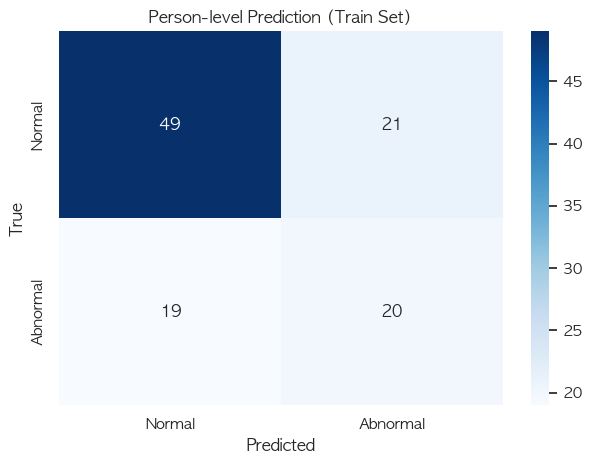

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

      Normal       0.67      0.56      0.61        18
    Abnormal       0.38      0.50      0.43        10

    accuracy                           0.54        28
   macro avg       0.53      0.53      0.52        28
weighted avg       0.57      0.54      0.54        28



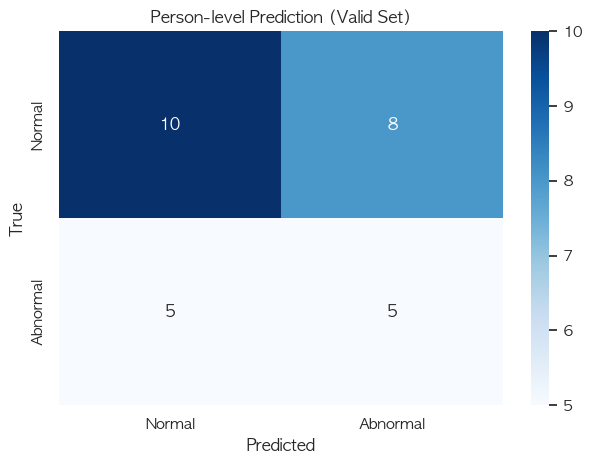

In [64]:
THRESHOLD = 0.45
person_preds_train = evaluate_person_level(
    model, X_train, y_train, emails_train,
    threshold=THRESHOLD, title="Person-level Prediction (Train Set)"
)
person_preds_test = evaluate_person_level(
    model, X_val, y_val, emails_val,
    threshold=THRESHOLD, title="Person-level Prediction (Valid Set)"
)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

      Normal       0.73      0.48      0.58        23
    Abnormal       0.45      0.71      0.56        14

    accuracy                           0.57        37
   macro avg       0.59      0.60      0.57        37
weighted avg       0.63      0.57      0.57        37



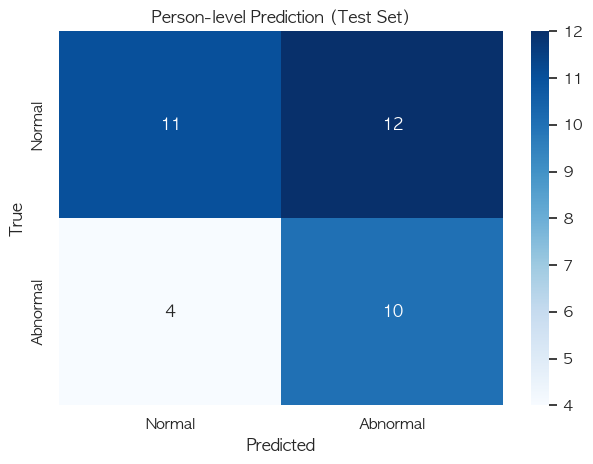

In [65]:

person_preds_test = evaluate_person_level(
    model, X_test, y_test, emails_test,
    threshold=THRESHOLD, title="Person-level Prediction (Test Set)"
)

### 일반 성능평가

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


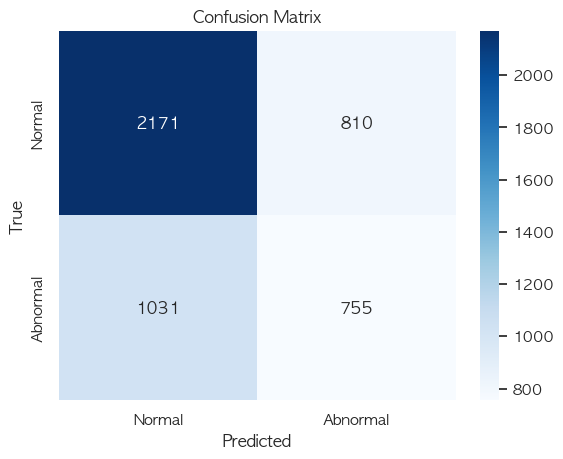

              precision    recall  f1-score   support

      Normal       0.68      0.73      0.70      2981
    Abnormal       0.48      0.42      0.45      1786

    accuracy                           0.61      4767
   macro avg       0.58      0.58      0.58      4767
weighted avg       0.60      0.61      0.61      4767



In [66]:
y_pred_prob = model.predict(X_train).flatten()
y_pred = (y_pred_prob >= THRESHOLD).astype(int)
# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_train, y_pred, target_names=['Normal', 'Abnormal']))

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


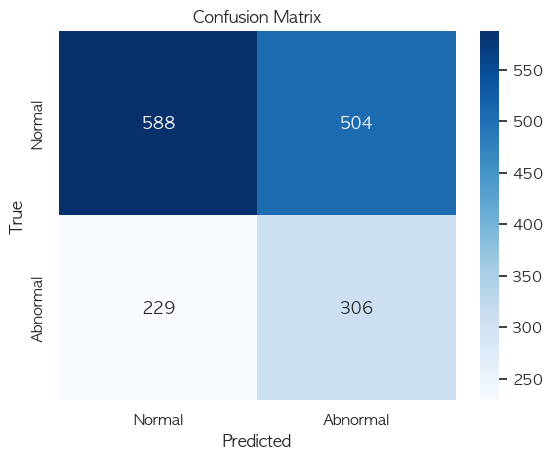

              precision    recall  f1-score   support

      Normal       0.72      0.54      0.62      1092
    Abnormal       0.38      0.57      0.46       535

    accuracy                           0.55      1627
   macro avg       0.55      0.56      0.54      1627
weighted avg       0.61      0.55      0.56      1627



In [67]:
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob >= THRESHOLD).astype(int)


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Normal', 'Abnormal']))

### ROC Curve

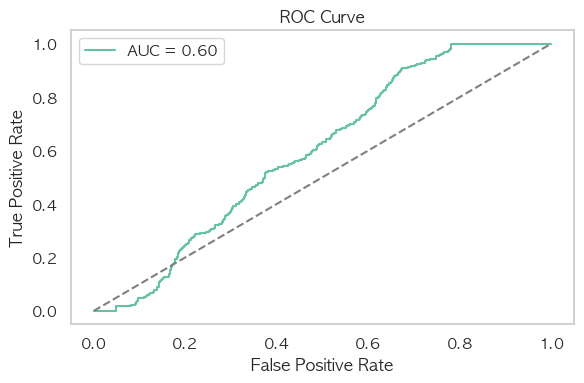

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## K-Fold 

In [53]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
import numpy as np
import pandas as pd

def build_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=input_shape),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [54]:
def run_lstm_kfold(df, feature_cols, label_col='label', seq_len=12, stride=1, k=5, seed=42):
    from collections import defaultdict
    from sklearn.utils import shuffle
    from sklearn.metrics import confusion_matrix

    def create_sequences(data, features, label, seq_len, stride=1, return_email=False):
        X, y, emails = [], [], []
        for person_id in data['EMAIL'].unique():
            person_data = data[data['EMAIL'] == person_id].sort_values('days_since_start')
            feature_data = person_data[features].values
            label_value = person_data[label].iloc[0]
            if len(feature_data) >= seq_len:
                for i in range(0, len(feature_data) - seq_len + 1, stride):
                    X.append(feature_data[i:i+seq_len])
                    y.append(label_value)
                    emails.append(person_id)
        if return_email:
            return np.array(X), np.array(y), np.array(emails)
        else:
            return np.array(X), np.array(y)

    def evaluate_person_level(model, X, y, emails, threshold=0.5):
        y_pred_prob = model.predict(X).flatten()
        y_pred = (y_pred_prob >= threshold).astype(int)
        df_pred = pd.DataFrame({
            'EMAIL': emails,
            'y_true': y,
            'y_pred_prob': y_pred_prob
        })
        df_person = df_pred.groupby('EMAIL').agg({
            'y_true': 'first',
            'y_pred_prob': 'mean'
        }).reset_index()
        df_person['y_pred'] = (df_person['y_pred_prob'] >= threshold).astype(int)
        return df_person

    results = []
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    email_labels = df.groupby("EMAIL")[label_col].first().reset_index()

    for fold, (train_idx, val_idx) in enumerate(skf.split(email_labels["EMAIL"], email_labels[label_col])):
        train_emails = email_labels.iloc[train_idx]["EMAIL"]
        val_emails = email_labels.iloc[val_idx]["EMAIL"]

        train_df = df[df["EMAIL"].isin(train_emails)]
        val_df = df[df["EMAIL"].isin(val_emails)]

        # 시퀀스 생성
        X_train, y_train, emails_train = create_sequences(train_df, feature_cols, label_col, seq_len, stride, return_email=True)
        X_val, y_val, emails_val = create_sequences(val_df, feature_cols, label_col, seq_len, stride, return_email=True)

        # 모델 학습
        model = build_lstm_model((seq_len, len(feature_cols)))
        # model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32,
            callbacks=[early_stop],
            class_weight=class_weights,
            verbose=1
        )

        # 사람 단위 평가
        val_result = evaluate_person_level(model, X_val, y_val, emails_val)
        report = classification_report(val_result["y_true"], val_result["y_pred"], target_names=["Normal", "Abnormal"], output_dict=True)
        acc = accuracy_score(val_result["y_true"], val_result["y_pred"])
        print(f"[Fold {fold+1}] Accuracy: {acc:.4f} | Abnormal Recall: {report['Abnormal']['recall']:.4f}")
        results.append(report)

    return results, model


In [55]:
# 시드 고정
seed_everything(42)

# 모델 훈련
kfold_results, KF_model = run_lstm_kfold(
    df=train_df,
    feature_cols=feature_cols,
    label_col='label',
    seq_len=28,
    stride=7,
    k=5,
    seed=42
)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5029 - loss: 0.6942 - val_accuracy: 0.4196 - val_loss: 0.7005
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4944 - loss: 0.6913 - val_accuracy: 0.5105 - val_loss: 0.6975
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5956 - loss: 0.6772 - val_accuracy: 0.4965 - val_loss: 0.7359
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5822 - loss: 0.6738 - val_accuracy: 0.5245 - val_loss: 0.7920
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5579 - loss: 0.6962 - val_accuracy: 0.5315 - val_loss: 0.7466
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6311 - loss: 0.6732 - val_accuracy: 0.4336 - val_loss: 0.8136
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6316 - loss: 0.6810 - val_accuracy: 0.4406 - val_loss: 0.8385
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5908 - loss: 0.6866 - val_accuracy: 0.4406 - val_loss

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

      Normal       0.66      0.57      0.61        70
    Abnormal       0.38      0.46      0.41        39

    accuracy                           0.53       109
   macro avg       0.52      0.52      0.51       109
weighted avg       0.56      0.53      0.54       109



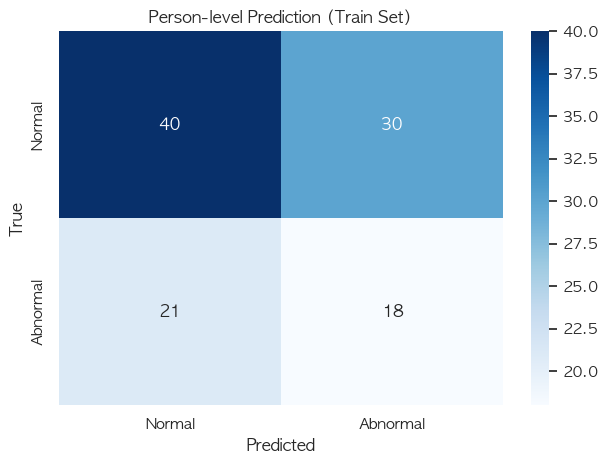

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

      Normal       0.71      0.56      0.62        18
    Abnormal       0.43      0.60      0.50        10

    accuracy                           0.57        28
   macro avg       0.57      0.58      0.56        28
weighted avg       0.61      0.57      0.58        28



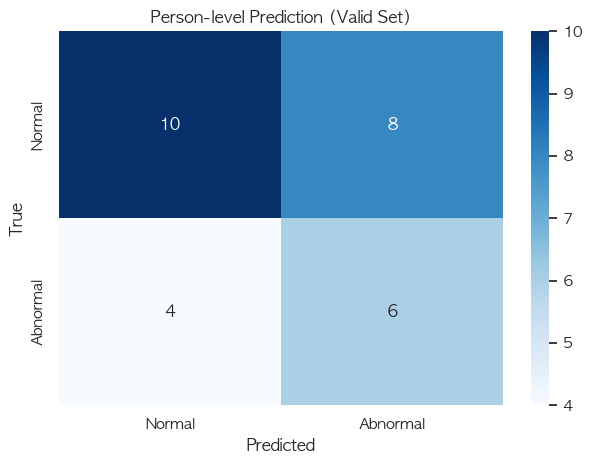

In [77]:
THRESHOLD = 0.45
person_preds_train = evaluate_person_level(
    KF_model, X_train, y_train, emails_train,
    threshold=THRESHOLD, title="Person-level Prediction (Train Set)"
)
person_preds_test = evaluate_person_level(
    KF_model, X_val, y_val, emails_val,
    threshold=THRESHOLD, title="Person-level Prediction (Valid Set)"
)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

      Normal       0.75      0.26      0.39        23
    Abnormal       0.41      0.86      0.56        14

    accuracy                           0.49        37
   macro avg       0.58      0.56      0.47        37
weighted avg       0.62      0.49      0.45        37



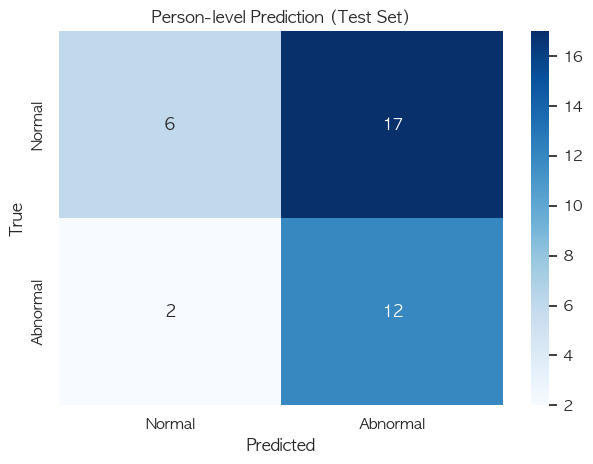

In [71]:

person_preds_test = evaluate_person_level(
    KF_model, X_test, y_test, emails_test,
    threshold=THRESHOLD, title="Person-level Prediction (Test Set)"
)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


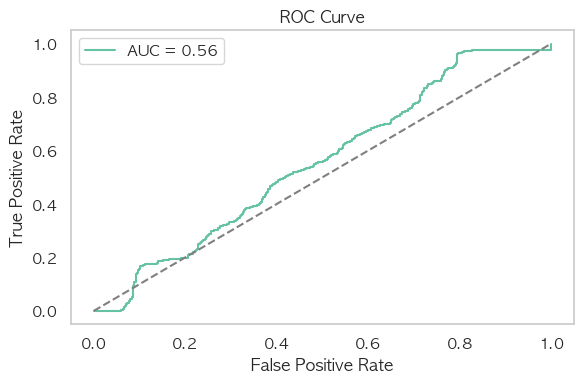

In [78]:
y_pred_prob = KF_model.predict(X_test).flatten()
y_pred = (y_pred_prob >= THRESHOLD).astype(int)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [59]:
from sklearn.metrics import f1_score

def permutation_importance_lstm(model, X_val, y_val, feature_names):
    baseline = f1_score(y_val, (model.predict(X_val) > 0.5).astype(int))
    importances = []

    for i in range(X_val.shape[2]):
        X_permuted = X_val.copy()
        X_permuted[:, :, i] = np.random.permutation(X_permuted[:, :, i])
        permuted_score = f1_score(y_val, (model.predict(X_permuted) > 0.5).astype(int))
        drop = baseline - permuted_score
        importances.append(drop)

    return pd.Series(importances, index=feature_names).sort_values(ascending=False)


In [60]:
permutation_importance_lstm(model, X_val, y_val, feature_cols)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


sleep_restless             0.075258
sleep_score_efficiency     0.028735
sleep_efficiency           0.011531
activity_total             0.000541
sleep_hr_average           0.000271
activity_steps             0.000000
activity_daily_movement    0.000000
sleep_rmssd                0.000000
sleep_midpoint_at_delta    0.000000
dtype: float64